# 📘 Project Overview

This notebook presents a solution to the **6th Edition of the Repsol - IE Sustainability Challenge**. The objective is to optimize CO₂ emission reductions in an industrial setting through three key tasks:

1. **Estimate maximum solar generation potential** for September 2024 based on meteorological data and historical patterns.
2. **Simulate battery storage optimization** using a 100 kWh battery to increase self-consumption of solar energy.
3. **Quantify avoided CO₂ emissions** resulting from improved solar energy utilization.

The approach integrates meteorological data processing, feature engineering, predictive modeling, and battery dispatch logic — all aligned with the datathon’s technical and business evaluation criteria.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
import os


---

# 🔍 1. Exploratory Data Analysis (EDA)

We begin by importing essential libraries for:

- Time series modeling and diagnostics
- Data visualization and plotting
- Machine learning and error evaluation

A custom plotting function `plot_eda` is defined to simultaneously display:
- A histogram of a selected variable
- A time series plot for the same

These tools help uncover trends, seasonality, and distribution characteristics — all important for building robust forecasting models.

---



In [2]:
def plot_eda(df, column_name, bins=30):
    """
    Plots side-by-side:
      1. A histogram of values in 'column_name'
      2. A line chart of the time series for 'column_name'
    
    Parameters:
      df (pandas.DataFrame): DataFrame with a DateTimeIndex
      column_name (str): Name of the column to plot
      bins (int): Number of bins to use in the histogram
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Histogram
    axes[0].hist(df[column_name].dropna(), bins=bins)
    axes[0].set_title(f"Distribution of {column_name}")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")
    
    # Time series line plot
    axes[1].plot(df.index, df[column_name])
    axes[1].set_title(f"Time Series of {column_name}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()

# ☀️ Weather Data Preparation

This section loads and processes the raw meteorological dataset required to estimate solar generation potential.

- The weather data comes in a CSV-like format embedded within an Excel file.
- We manually split and reformat it into a clean tabular structure.
- Timestamps are parsed, and all values are cast to numeric types.

To match the plant's location as closely as possible:

- We calculate Euclidean distances to determine the 4 **closest GFS grid points** to the factory in Pinto.
- Weather values are averaged across these coordinates, producing a **localized time series**.
- Finally, we rename all meteorological variables for readability and export the result as `processed/weather_data.csv`.

This processed dataset becomes the foundation for the solar potential modeling in Objective 1.

---



Weather data comes in an excel will all the data in one column with what seams to be comma separated values. We are going to read and save properly the data. 

In [ ]:
## Let's read the Excel without any header
raw_weather = pd.read_excel("data/raw/Meteorologia.xlsx", header=None)
# We are going to extract the columns
raw_weather_columns = raw_weather.iloc[0,0]
raw_weather_columns = raw_weather_columns.split(',')
# Then we are going to separate the values using the commas
raw_weather_data = raw_weather.iloc[1:,:]
raw_weather_data = raw_weather_data[0].str.split(',', expand=True)
raw_weather_data.columns= raw_weather_columns
# Now that we have the data we are going to parse properly the date
raw_weather_data['date'] = pd.to_datetime(raw_weather_data['FORECAST_TIMESTAMP'])
weather_data = raw_weather_data.set_index('date').drop(columns='FORECAST_TIMESTAMP')
# Let's clear space in memory
del raw_weather_data
del raw_weather
for column in weather_data.columns:
    weather_data[column] = pd.to_numeric(weather_data[column])
os.makedirs('data/raw', exist_ok=True)
weather_data.to_csv('data/raw/weather_data.csv')

Now that we have our clean data, we are going to filter down to the 4 closest weather stations so we can have our estimated weather data for our industry in Pinto. 

In [4]:
weather_data['coordinates'] = list(zip(weather_data['LATITUDE'], weather_data['LONGITUDE']))
coordinates = weather_data['coordinates'].unique()
coordinates = pd.DataFrame(coordinates, columns=['coordinates'])
coordinates

,coordinates
0,"(40.0, -4.0)"
1,"(40.0, -3.75)"
2,"(40.0, -3.5)"
3,"(40.25, -4.0)"
4,"(40.25, -3.75)"
5,"(40.25, -3.5)"
6,"(40.5, -4.0)"
7,"(40.5, -3.75)"
8,"(40.5, -3.5)"


Let's define the function to get the distance from Pinto so we can then get the 4 nearest stations. This is sort of a manual knn filling of the data.

In [5]:
import math
def euclidean_distance_pinto(tuple1):
    lat_lon_pinto = (40.2375, -3.6968)
    distance = math.sqrt((lat_lon_pinto[0] - tuple1[0])**2 + (lat_lon_pinto[1] - tuple1[1])**2)
    return distance

coordinates['distance'] = coordinates.apply(lambda row: euclidean_distance_pinto(row['coordinates']),axis=1)
coordinates.head()

,coordinates,distance
0,"(40.0, -4.0)",0.385145
1,"(40.0, -3.75)",0.243385
2,"(40.0, -3.5)",0.308442
3,"(40.25, -4.0)",0.303458
4,"(40.25, -3.75)",0.054649


In [6]:
included_stations = coordinates.sort_values('distance', ascending=True).reset_index().loc[:3,'coordinates']
included_stations = included_stations.to_list()
included_stations

[(40.25, -3.75), (40.25, -3.5), (40.0, -3.75), (40.5, -3.75)]

In [7]:
weather_data = weather_data[weather_data['coordinates'].isin(included_stations)]
weather_data.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,...,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,coordinates
date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.0,-3.75,6.629717,1.254463,17.5,0.004574,301.767859,18000.0,300.344031,319.80769,...,0.0,299.078662,301.832129,292.501489,322.706396,0.0,316.600012,7.379102,1.483457,"(40.0, -3.75)"
2023-07-24 12:00:00+00:00,40.0,-3.75,7.186357,1.511797,17.3,0.004918,303.265576,21600.0,301.370923,323.60769,...,0.0,300.400000,303.263452,292.501489,323.303369,0.0,318.500000,8.081675,1.803066,"(40.0, -3.75)"
2023-07-24 13:00:00+00:00,40.0,-3.75,7.806143,1.284370,17.1,0.005276,304.654614,3600.0,302.603198,353.40000,...,60.2,301.895581,304.615100,303.200000,324.496606,0.0,319.577295,8.977305,1.582959,"(40.0, -3.75)"
2023-07-24 14:00:00+00:00,40.0,-3.75,9.322205,0.843123,17.0,0.005565,305.581506,7200.0,303.444031,359.14873,...,5.0,302.944043,305.589685,303.200000,326.790967,0.0,318.415942,10.752161,1.211703,"(40.0, -3.75)"
2023-07-24 15:00:00+00:00,40.0,-3.75,9.707048,1.075879,17.2,0.005734,306.076172,10800.0,303.834607,362.30000,...,5.0,303.632275,306.095581,303.200000,328.955933,0.0,316.835266,11.256921,1.411133,"(40.0, -3.75)"


In [8]:
### Let's average out the closest stations data to have our model data for Pinto
weather_data = weather_data.drop(columns=['LATITUDE', 'LONGITUDE', 'coordinates'])
weather_data_grouped = weather_data.groupby(weather_data.index, dropna=True).mean()
weather_data = weather_data_grouped
weather_data.head()

,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,5.552217,2.449463,17.100,0.004546,301.942859,18000.0,300.419031,320.40769,570.110,7.175171,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.0,314.950012,6.439102,2.633457
2023-07-24 12:00:00+00:00,5.856357,3.034297,16.850,0.004803,303.165576,21600.0,301.320923,323.98269,635.764,8.005784,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.0,316.800000,6.899175,3.333066
2023-07-24 13:00:00+00:00,6.528643,3.126870,16.650,0.005111,304.404614,3600.0,302.353198,351.37500,980.375,8.903244,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.0,317.627295,7.832305,3.467959
2023-07-24 14:00:00+00:00,7.584705,2.043123,17.275,0.005530,305.131506,7200.0,302.994031,355.97373,956.795,9.585358,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.0,316.915942,9.052161,2.211703
2023-07-24 15:00:00+00:00,7.519548,2.373379,17.225,0.005634,305.551172,10800.0,303.409607,359.47500,916.180,9.929451,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.0,315.610266,8.981921,2.736133


now let's localize our weather data in our Madrid timezone so we can use it later in our analysis

In [9]:
print(weather_data.index.tz)
weather_data.index = weather_data.index.tz_convert('Europe/Madrid')
print(weather_data.index.tz)

UTC
Europe/Madrid


In [10]:
meteorologia_column_renames = {
    "10uheightAboveGround_10": "wind_u_10m",  # East-West wind component at 10m
    "10vheightAboveGround_10": "wind_v_10m",  # North-South wind component at 10m
    "2rheightAboveGround_2": "relative_humidity_2m",
    "2shheightAboveGround_2": "specific_humidity_2m",
    "2theightAboveGround_2": "air_temp_2m_K",
    "SUNSDsurface_0": "sunshine_duration_s",  # Duration of sunshine (seconds)
    "aptmpheightAboveGround_2": "apparent_temp_2m_K",
    "dlwrfsurface_0": "longwave_radiation_wm2",  # Downward longwave radiation
    "dswrfsurface_0": "shortwave_radiation_wm2",  # Downward shortwave radiation
    "gustsurface_0": "wind_gusts_surface_ms",
    "msletmeanSea_0": "mean_sea_level_pressure_pa",
    "presheightAboveGround_80": "pressure_80m_pa",
    "pwatatmosphereSingleLayer_0": "precipitable_water_kgm2",
    "qheightAboveGround_80": "specific_humidity_80m",
    "spsurface_0": "surface_pressure_pa",
    "tccatmosphere_0": "total_cloud_cover_pct",
    "theightAboveGround_80": "air_temp_80m_K",
    "tmaxheightAboveGround_2": "max_air_temp_2m_K",
    "tminheightAboveGround_2": "min_air_temp_2m_K",
    "tozneatmosphereSingleLayer_0": "ozone_total_DU",  # Dobson Units
    "tpsurface_0": "accumulated_precip_mm",
    "tsurface_0": "surface_temp_K",
    "uheightAboveGround_80": "wind_u_80m",  # East-West wind component at 80m
    "vheightAboveGround_80": "wind_v_80m",  # North-South wind component at 80m
}


weather_data = weather_data.rename(columns=meteorologia_column_renames)


In [11]:
weather_data.head()

,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,air_temp_2m_K,sunshine_duration_s,apparent_temp_2m_K,longwave_radiation_wm2,shortwave_radiation_wm2,wind_gusts_surface_ms,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 13:00:00+02:00,5.552217,2.449463,17.100,0.004546,301.942859,18000.0,300.419031,320.40769,570.110,7.175171,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.0,314.950012,6.439102,2.633457
2023-07-24 14:00:00+02:00,5.856357,3.034297,16.850,0.004803,303.165576,21600.0,301.320923,323.98269,635.764,8.005784,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.0,316.800000,6.899175,3.333066
2023-07-24 15:00:00+02:00,6.528643,3.126870,16.650,0.005111,304.404614,3600.0,302.353198,351.37500,980.375,8.903244,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.0,317.627295,7.832305,3.467959
2023-07-24 16:00:00+02:00,7.584705,2.043123,17.275,0.005530,305.131506,7200.0,302.994031,355.97373,956.795,9.585358,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.0,316.915942,9.052161,2.211703
2023-07-24 17:00:00+02:00,7.519548,2.373379,17.225,0.005634,305.551172,10800.0,303.409607,359.47500,916.180,9.929451,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.0,315.610266,8.981921,2.736133


In [ ]:
os.makedirs('data/processed', exist_ok=True)
weather_data.to_csv('data/processed/weather_data.csv')

# 🔆 Visual Inspection: Solar Generation Trends

This section visualizes solar energy generation between **March 25 and May 2, 2024** to assess:

- Daily and hourly fluctuations
- Overall trends and potential anomalies
- Whether weekends or holidays show reduced output

This visualization helps confirm assumptions like regular daily cycles and guides the modeling of hourly solar potential for September.

---



In [13]:
### Generación fotovoltaica. Date and Times are already in Madrid Local/Time.
solar_gen = pd.read_csv('data/raw/Generacion_fotovoltaica.csv')
solar_gen['datetime'] = pd.to_datetime(solar_gen['FECHA'])
solar_gen = solar_gen.set_index('datetime').drop(columns=['FECHA']).rename(columns={'TOTAL_KWH_ENERGIA': 'solar_gen_kwh'})
print(solar_gen.dtypes)
print(solar_gen.head())
print("\nNull Values: ",solar_gen.isna().sum())
solar_gen.describe()

solar_gen_kwh    float64
dtype: object
                     solar_gen_kwh
datetime                          
2023-07-24 11:00:00            NaN
2023-07-24 12:00:00         115.66
2023-07-24 13:00:00         129.98
2023-07-24 14:00:00         134.35
2023-07-24 15:00:00         133.90

Null Values:  solar_gen_kwh    1164
dtype: int64


,solar_gen_kwh
count,8544.000000
mean,25.395279
std,40.258814
min,-0.150000
25%,0.000000
50%,0.990000
75%,32.635000
max,153.050000


In [14]:
solar_gen['day_of_week'] = solar_gen.index.day_of_week
solar_gen['hour'] = solar_gen.index.hour
hourly_avg = solar_gen.groupby(solar_gen.index.hour)['solar_gen_kwh'].mean()
hourly_avg

datetime
0      0.003128
1     -0.003520
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.023549
8      1.183267
9      7.760632
10    28.695621
11    50.621836
12    69.027119
13    78.345480
14    80.106723
15    76.471158
16    71.214479
17    60.665686
18    44.756648
19    26.658156
20    12.578520
21     2.978687
22     0.285475
23    -0.005559
Name: solar_gen_kwh, dtype: float64

Let's fill nulls during the night with a 0. It will not harm the dataset too much.

In [15]:
solar_gen[(solar_gen['solar_gen_kwh'].isna()) & (solar_gen['hour'].isin([23,0,1,2,3,4,5,6]))] = 0
solar_gen.isna().sum()

solar_gen_kwh    795
day_of_week        0
hour               0
dtype: int64

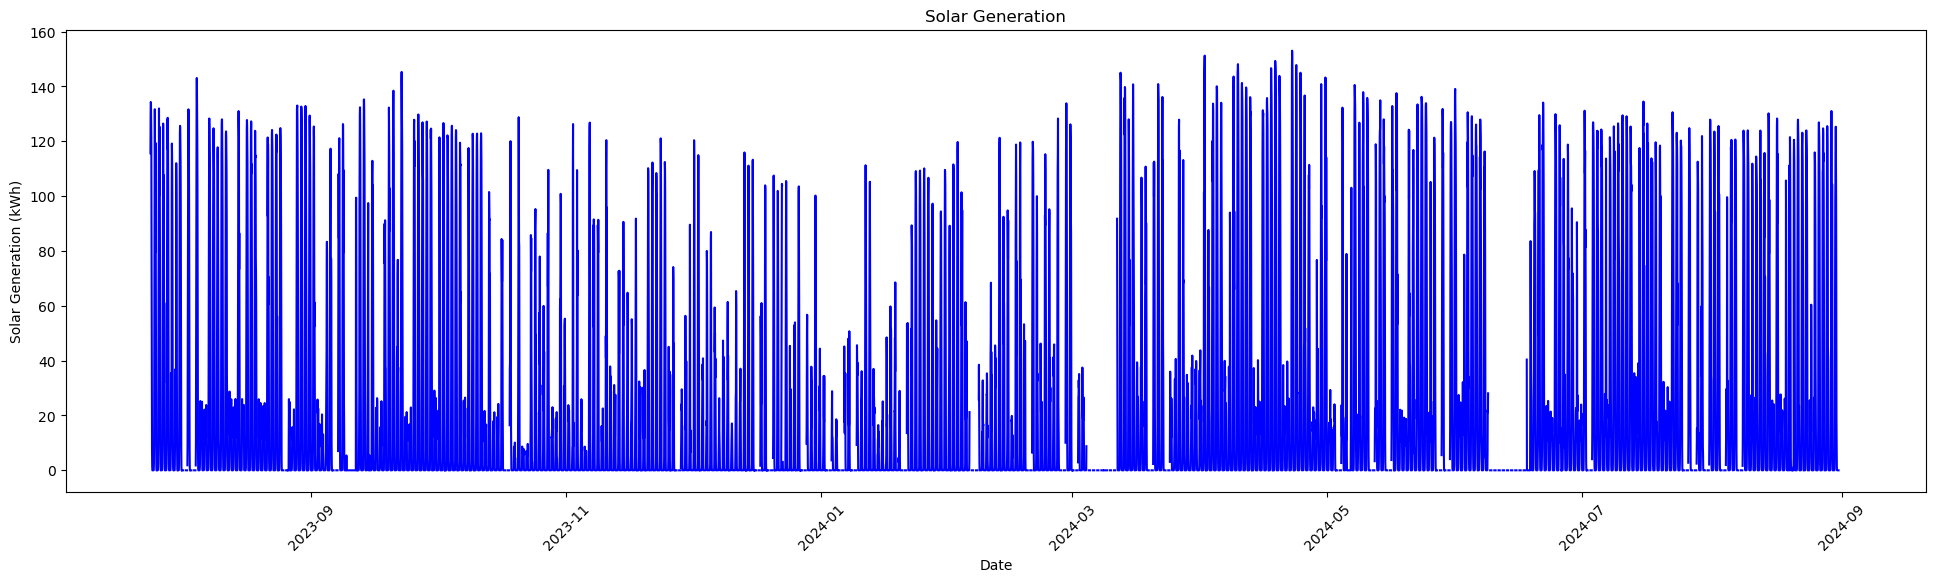

In [16]:
plt.figure(figsize=(24,6))
plt.plot(solar_gen['solar_gen_kwh'], color = "blue")
plt.ylabel('Solar Generation (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Solar Generation")
plt.show()

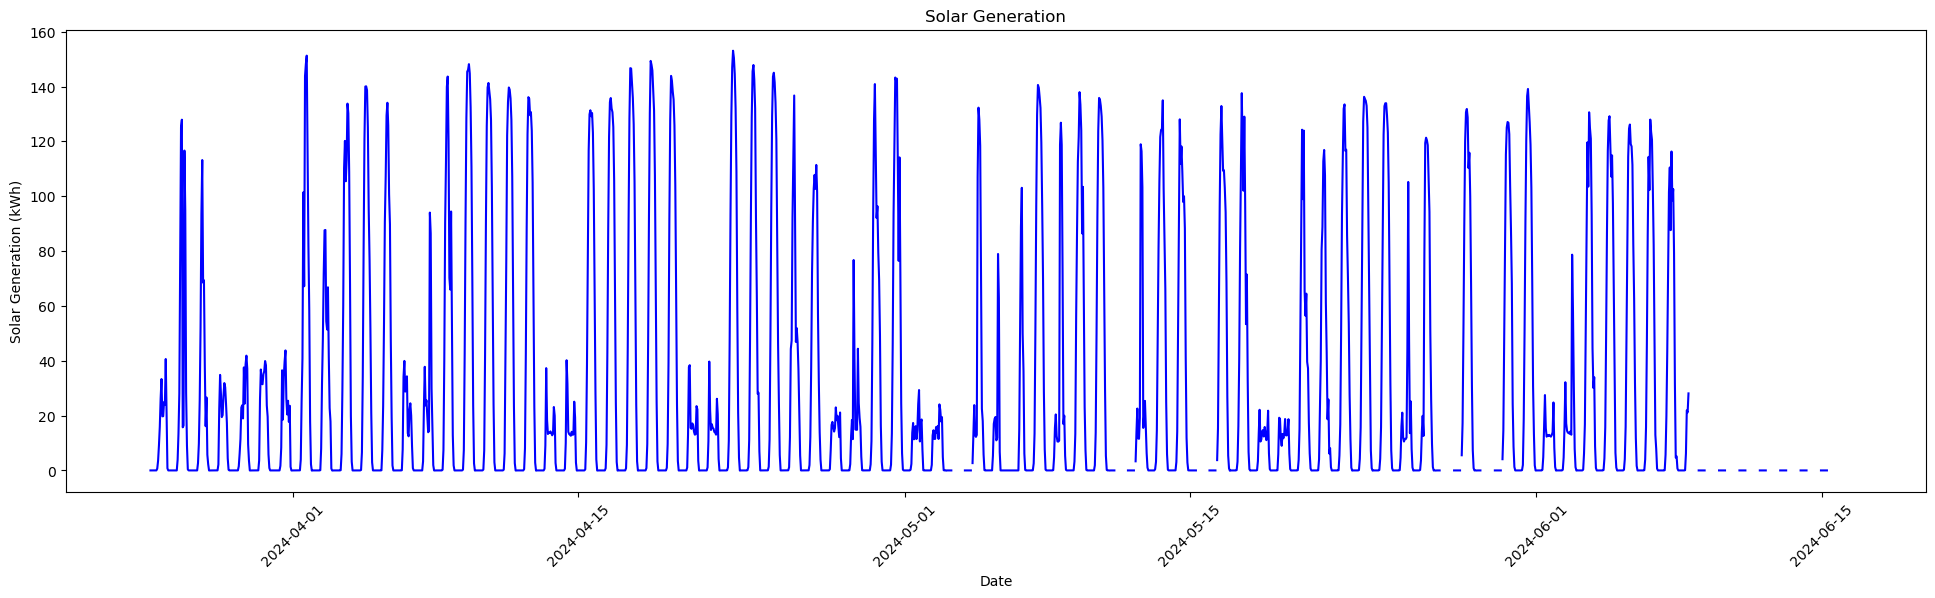

In [17]:
plt.figure(figsize=(24,6))
plt.plot(solar_gen['solar_gen_kwh']['2024-03-25':'2024-06-15'], color = "blue")
plt.ylabel('Solar Generation (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Solar Generation")
plt.show()

<Figure size 800x500 with 0 Axes>

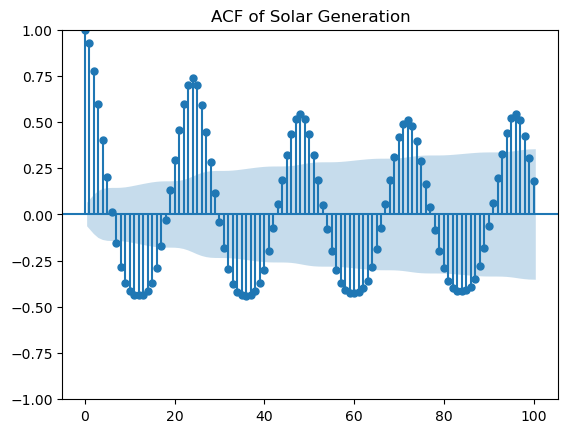

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

solar_gen_subset = solar_gen['2024-03-25':'2024-05-02']

# Plot ACF of Solar Generation
plt.figure(figsize=(8, 5))
plot_acf(solar_gen_subset['solar_gen_kwh'], lags=100)
plt.title("ACF of Solar Generation")
plt.show()

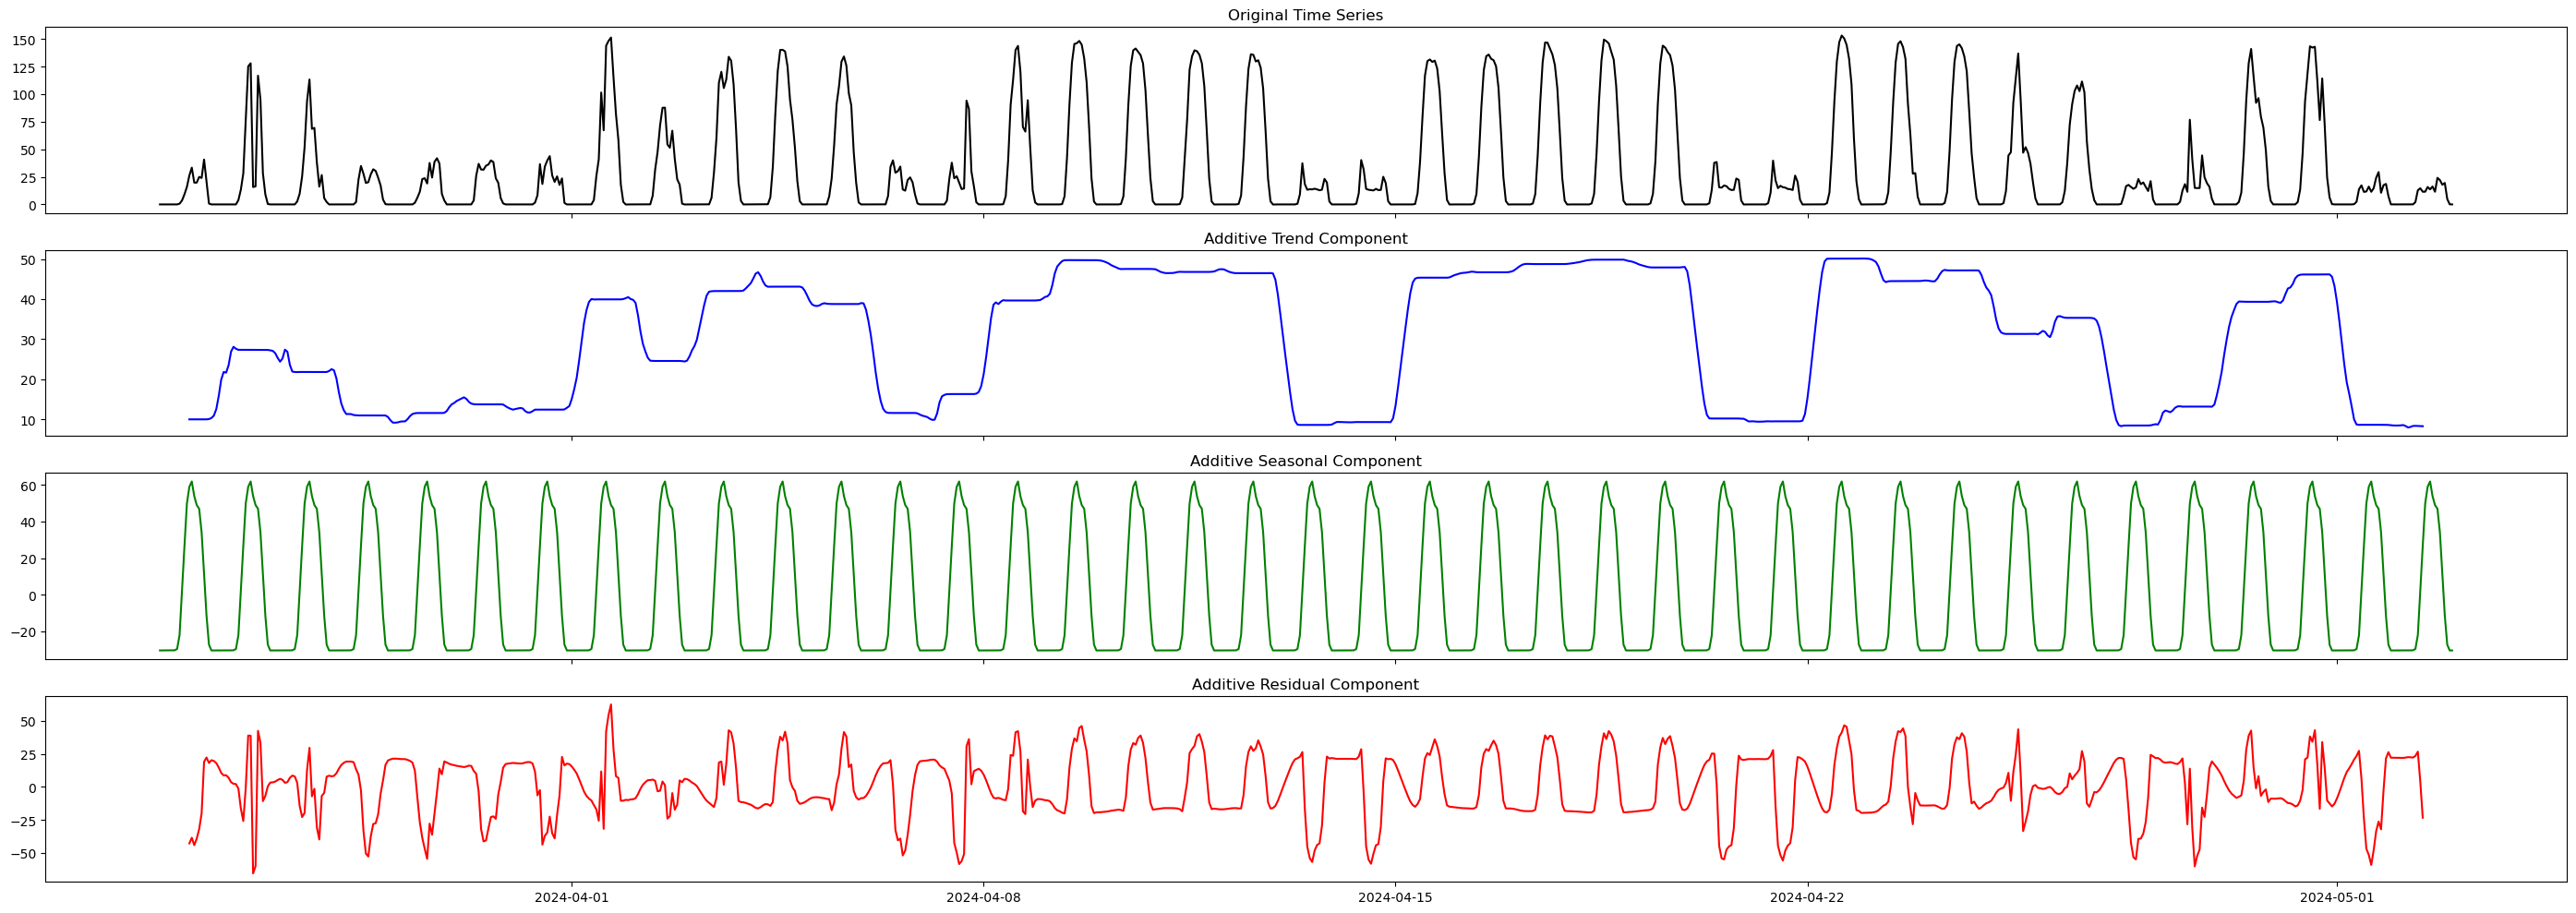

In [19]:

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(solar_gen_subset['solar_gen_kwh'], model="additive", period=24)


# Plot both decompositions side by side
fig, axes = plt.subplots(4, 1, figsize=(28, 10), sharex=True)

# Additive Decomposition Plots
axes[0].plot(solar_gen_subset.index, solar_gen_subset['solar_gen_kwh'], color="black")
axes[0].set_title("Original Time Series")

axes[1].plot(solar_gen_subset.index, additive_decomposition.trend, color="blue")
axes[1].set_title("Additive Trend Component")

axes[2].plot(solar_gen_subset.index, additive_decomposition.seasonal, color="green")
axes[2].set_title("Additive Seasonal Component")

axes[3].plot(solar_gen_subset.index, additive_decomposition.resid, color="red")
axes[3].set_title("Additive Residual Component")

plt.tight_layout()
plt.show()

Let's localize our Naive time in Madrid and assign NAT to the conflictive values. As they happen during the night we will fill the solar generation with zeros

In [20]:
solar_gen.index = solar_gen.index.tz_localize('Europe/Madrid', ambiguous='NaT', nonexistent='shift_forward')
solar_gen = solar_gen[~solar_gen.index.isna()]
solar_gen.describe()

,solar_gen_kwh,day_of_week,hour
count,8912.000000,9707.000000,9707.000000
mean,24.346640,2.877923,11.298444
std,39.741318,2.041107,7.051607
min,-0.150000,0.000000,0.000000
25%,0.000000,1.000000,5.000000
50%,0.220000,3.000000,11.000000
75%,29.365000,5.000000,17.000000
max,153.050000,6.000000,23.000000


In [21]:
weekly_avg = solar_gen.groupby(solar_gen.index.day_of_week)['solar_gen_kwh'].mean()
weekly_avg

datetime
0    28.954021
1    29.383766
2    29.729002
3    27.006725
4    31.457053
5    11.298975
6    12.625455
Name: solar_gen_kwh, dtype: float64

# 📊 Feature Engineering: Temporal Patterns and Holiday Adjustment

We extend the solar generation dataset by engineering meaningful time-based features:

- `day_of_week`, `hour`, and `date` columns are added to encode daily cycles.
- Using the `holidays` library for Spain (Madrid), we identify official holidays and flag them as **non-working days**.
- This adjustment ensures our model captures realistic drops in solar usage — which occur due to factory downtime — even during ideal weather.

Notably, during Easter and "Puente de Mayo," solar generation drops sharply despite good sunlight,so we are going to treat them as if they were weekends. These patterns are essential for accurate model learning.

---


In [22]:
import holidays
madrid_holidays = holidays.Spain(subdiv='MD', years=range(2023, 2025))

In [23]:
dict(madrid_holidays)

{datetime.date(2024, 1, 1): 'Año Nuevo',
 datetime.date(2024, 1, 6): 'Epifanía del Señor',
 datetime.date(2024, 3, 29): 'Viernes Santo',
 datetime.date(2024, 5, 1): 'Fiesta del Trabajo',
 datetime.date(2024, 8, 15): 'Asunción de la Virgen',
 datetime.date(2024, 10, 12): 'Fiesta Nacional de España',
 datetime.date(2024, 11, 1): 'Todos los Santos',
 datetime.date(2024, 12, 6): 'Día de la Constitución Española',
 datetime.date(2024, 12, 25): 'Natividad del Señor',
 datetime.date(2024, 3, 28): 'Jueves Santo',
 datetime.date(2024, 5, 2): 'Fiesta de la Comunidad de Madrid',
 datetime.date(2024, 7, 25): 'Santiago Apóstol',
 datetime.date(2023, 1, 6): 'Epifanía del Señor',
 datetime.date(2023, 4, 7): 'Viernes Santo',
 datetime.date(2023, 5, 1): 'Fiesta del Trabajo',
 datetime.date(2023, 8, 15): 'Asunción de la Virgen',
 datetime.date(2023, 10, 12): 'Fiesta Nacional de España',
 datetime.date(2023, 11, 1): 'Todos los Santos',
 datetime.date(2023, 12, 6): 'Día de la Constitución Española',
 date

In [24]:
solar_gen['working_day'] = (solar_gen['day_of_week'] < 5).astype(int)
solar_gen['date'] = solar_gen.index.date
solar_gen['working_day'] = solar_gen.apply(lambda row: 0 if row['date'] in madrid_holidays else row['working_day'], axis=1)
solar_gen['2024-04-30':'2024-05-02'].head(50)

,solar_gen_kwh,day_of_week,hour,working_day,date
datetime,,,,,
2024-04-30 00:00:00+02:00,0.00,1,0,1,2024-04-30
2024-04-30 01:00:00+02:00,0.00,1,1,1,2024-04-30
2024-04-30 02:00:00+02:00,0.00,1,2,1,2024-04-30
2024-04-30 03:00:00+02:00,0.00,1,3,1,2024-04-30
2024-04-30 04:00:00+02:00,0.00,1,4,1,2024-04-30
2024-04-30 05:00:00+02:00,0.00,1,5,1,2024-04-30
2024-04-30 06:00:00+02:00,0.00,1,6,1,2024-04-30
2024-04-30 07:00:00+02:00,0.02,1,7,1,2024-04-30
2024-04-30 08:00:00+02:00,2.09,1,8,1,2024-04-30


Now there is a clear seasonal component but it is not linear so we are going to try a different approach. As there are two seasonalities, we are going to try and use our local daily maximum as a base point and create and hours_from_maximum field that can encode that daily variability properly. Furthermore, we can expand this idea to the year and have the summer solstice as a base point. 

---

# 🧠 Feature Expansion & Seasonality Engineering

This section builds advanced features to better capture nonlinear and periodic components in solar generation:

- Recognizing that solar output follows a **non-symmetric daily bell curve**, the idea of `hours_from_maximum` is introduced — measuring time distance from the peak irradiance per day.
- Additionally, this approach is extended to the **yearly cycle** by anchoring seasonality around the **summer solstice**, enhancing our ability to model sunlight variability over the year.

This type of **domain-driven feature engineering** plays a key role in accurately predicting solar generation, especially as we seek low-MAE results in Objective 1.

---


In [25]:
peak_hr = 14

def hours_to_closest_peak(hour):
    difference = abs(hour - peak_hr)
    return min(difference, 24 - difference)

hours_to_closest_peak(2)

solar_gen['h_from_max'] = solar_gen.apply(lambda row: hours_to_closest_peak(row['hour']), axis=1)
solar_gen.head()

,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max
datetime,,,,,,
2023-07-24 11:00:00+02:00,NaN,0,11,1,2023-07-24,3
2023-07-24 12:00:00+02:00,115.66,0,12,1,2023-07-24,2
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1


In [26]:
def days_to_closest_summer_solstice(date: pd.Timestamp) -> int:
    # Ensure the input date is timezone-naive
    date = date.tz_localize(None)

    year = date.year
    solstices = [
        pd.Timestamp(f"{year - 1}-06-21"),
        pd.Timestamp(f"{year}-06-21"),
        pd.Timestamp(f"{year + 1}-06-21"),
    ]
    
    differences = [abs((date - solstice).days) for solstice in solstices]
    return min(differences)

solar_gen['days_from_solstice'] = solar_gen.index.to_series().apply(days_to_closest_summer_solstice)
solar_gen.head()

,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max,days_from_solstice
datetime,,,,,,,
2023-07-24 11:00:00+02:00,NaN,0,11,1,2023-07-24,3,33
2023-07-24 12:00:00+02:00,115.66,0,12,1,2023-07-24,2,33
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1,33
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0,33
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1,33


In [27]:
solar_gen.to_csv('data/processed/solar_gen.csv')

Now we can merge the solar_gen and the weather_data dataframes to start analyzing the solar generation.

In [28]:
solar_weather = pd.merge(solar_gen, weather_data, how='inner', left_index=True, right_index=True)
solar_weather

,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max,days_from_solstice,wind_u_10m,wind_v_10m,relative_humidity_2m,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1,33,5.552217,2.449463,17.100,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.000000,314.950012,6.439102,2.633457
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0,33,5.856357,3.034297,16.850,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.000000,316.800000,6.899175,3.333066
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1,33,6.528643,3.126870,16.650,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.000000,317.627295,7.832305,3.467959
2023-07-24 16:00:00+02:00,126.93,0,16,1,2023-07-24,2,33,7.584705,2.043123,17.275,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.000000,316.915942,9.052161,2.211703
2023-07-24 17:00:00+02:00,121.22,0,17,1,2023-07-24,3,33,7.519548,2.373379,17.225,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.000000,315.610266,8.981921,2.736133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00+02:00,NaN,5,19,0,2024-08-31,5,71,1.973801,1.823562,40.900,...,94141.368750,98.275,301.075000,302.820093,299.638428,302.262988,0.250000,303.493311,2.525242,2.294253
2024-08-31 20:00:00+02:00,NaN,5,20,0,2024-08-31,6,71,0.700432,1.862703,44.800,...,94119.668750,47.900,300.334033,302.820093,299.188428,301.972119,0.406250,301.252832,1.310281,2.537390
2024-08-31 21:00:00+02:00,NaN,5,21,0,2024-08-31,7,71,1.102878,1.121714,49.600,...,94145.068750,13.225,300.003540,300.993335,299.765186,303.260889,0.031250,299.074316,2.017695,1.560337
2024-08-31 22:00:00+02:00,NaN,5,22,0,2024-08-31,8,71,0.578440,0.726792,51.425,...,94168.065625,99.200,299.658203,300.965186,299.345117,304.266699,0.046875,298.475000,1.210718,0.945347


In [29]:
solar_weather.drop(columns='date', inplace=True)
solar_weather.corr()

,solar_gen_kwh,day_of_week,hour,working_day,h_from_max,days_from_solstice,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
solar_gen_kwh,1.000000,-0.106990,0.294505,0.205397,-0.695540,-0.167964,0.061439,0.046190,-0.400777,-0.066207,...,0.026384,-0.124815,0.265955,0.256844,0.206082,0.032616,-0.082617,0.582708,0.028465,0.034140
day_of_week,-0.106990,1.000000,0.092617,-0.735901,-0.066214,0.017347,-0.001125,0.058361,-0.027222,-0.008395,...,-0.044735,0.022524,0.013886,0.008316,0.008890,-0.015645,0.041001,0.018119,-0.001109,0.061734
hour,0.294505,0.092617,1.000000,-0.037965,-0.516462,0.004572,0.210997,0.092768,-0.263163,-0.077230,...,-0.046750,0.022549,0.203057,0.177394,0.203871,-0.016660,-0.005775,0.279483,0.196369,0.084155
working_day,0.205397,-0.735901,-0.037965,1.000000,0.026906,-0.033451,-0.018597,-0.056043,-0.011071,0.032510,...,0.051201,-0.027353,0.035649,0.038173,0.036629,-0.026874,-0.006552,0.028215,-0.019303,-0.057884
h_from_max,-0.695540,-0.066214,-0.516462,0.026906,1.000000,0.000503,-0.151562,-0.123527,0.248243,0.030561,...,-0.000707,-0.015271,-0.106557,-0.088513,-0.051714,-0.004448,0.015555,-0.455118,-0.116141,-0.110784
days_from_solstice,-0.167964,0.017347,0.004572,-0.033451,0.000503,1.000000,0.134238,0.054370,0.572629,-0.253130,...,0.317912,0.237689,-0.660481,-0.701035,-0.661126,-0.331990,0.060881,-0.635582,0.152435,0.055886
wind_u_10m,0.061439,-0.001125,0.210997,-0.018597,-0.151562,0.134238,1.000000,0.403498,0.213964,-0.058195,...,-0.434768,0.230430,-0.182614,-0.170549,-0.139722,0.173966,0.072500,-0.084913,0.993298,0.355606
wind_v_10m,0.046190,0.058361,0.092768,-0.056043,-0.123527,0.054370,0.403498,1.000000,0.187159,0.297729,...,-0.377374,0.333845,0.048992,0.038775,0.061785,-0.050814,0.180379,0.088050,0.421470,0.992996
relative_humidity_2m,-0.400777,-0.027222,-0.263163,-0.011071,0.248243,0.572629,0.213964,0.187159,1.000000,0.222364,...,-0.060285,0.427779,-0.811611,-0.798631,-0.766040,0.112031,0.227290,-0.775693,0.245191,0.187285
specific_humidity_2m,-0.066207,-0.008395,-0.077230,0.032510,0.030561,-0.253130,-0.058195,0.297729,0.222364,1.000000,...,-0.225230,0.188856,0.292618,0.310454,0.324726,-0.184862,0.200026,0.254946,-0.049360,0.309552


# 🔁 Correlation Analysis

Before modeling, we use a **correlation heatmap** to inspect multicollinearity between variables in the merged solar + weather dataset:

- This helps ensure redundant or highly correlated variables are identified.
- It also informs model feature selection — especially for tree-based models like Gradient Boosting.

The processed dataset is saved as `solar_weather.csv` for training and prediction tasks.

---

<Axes: >

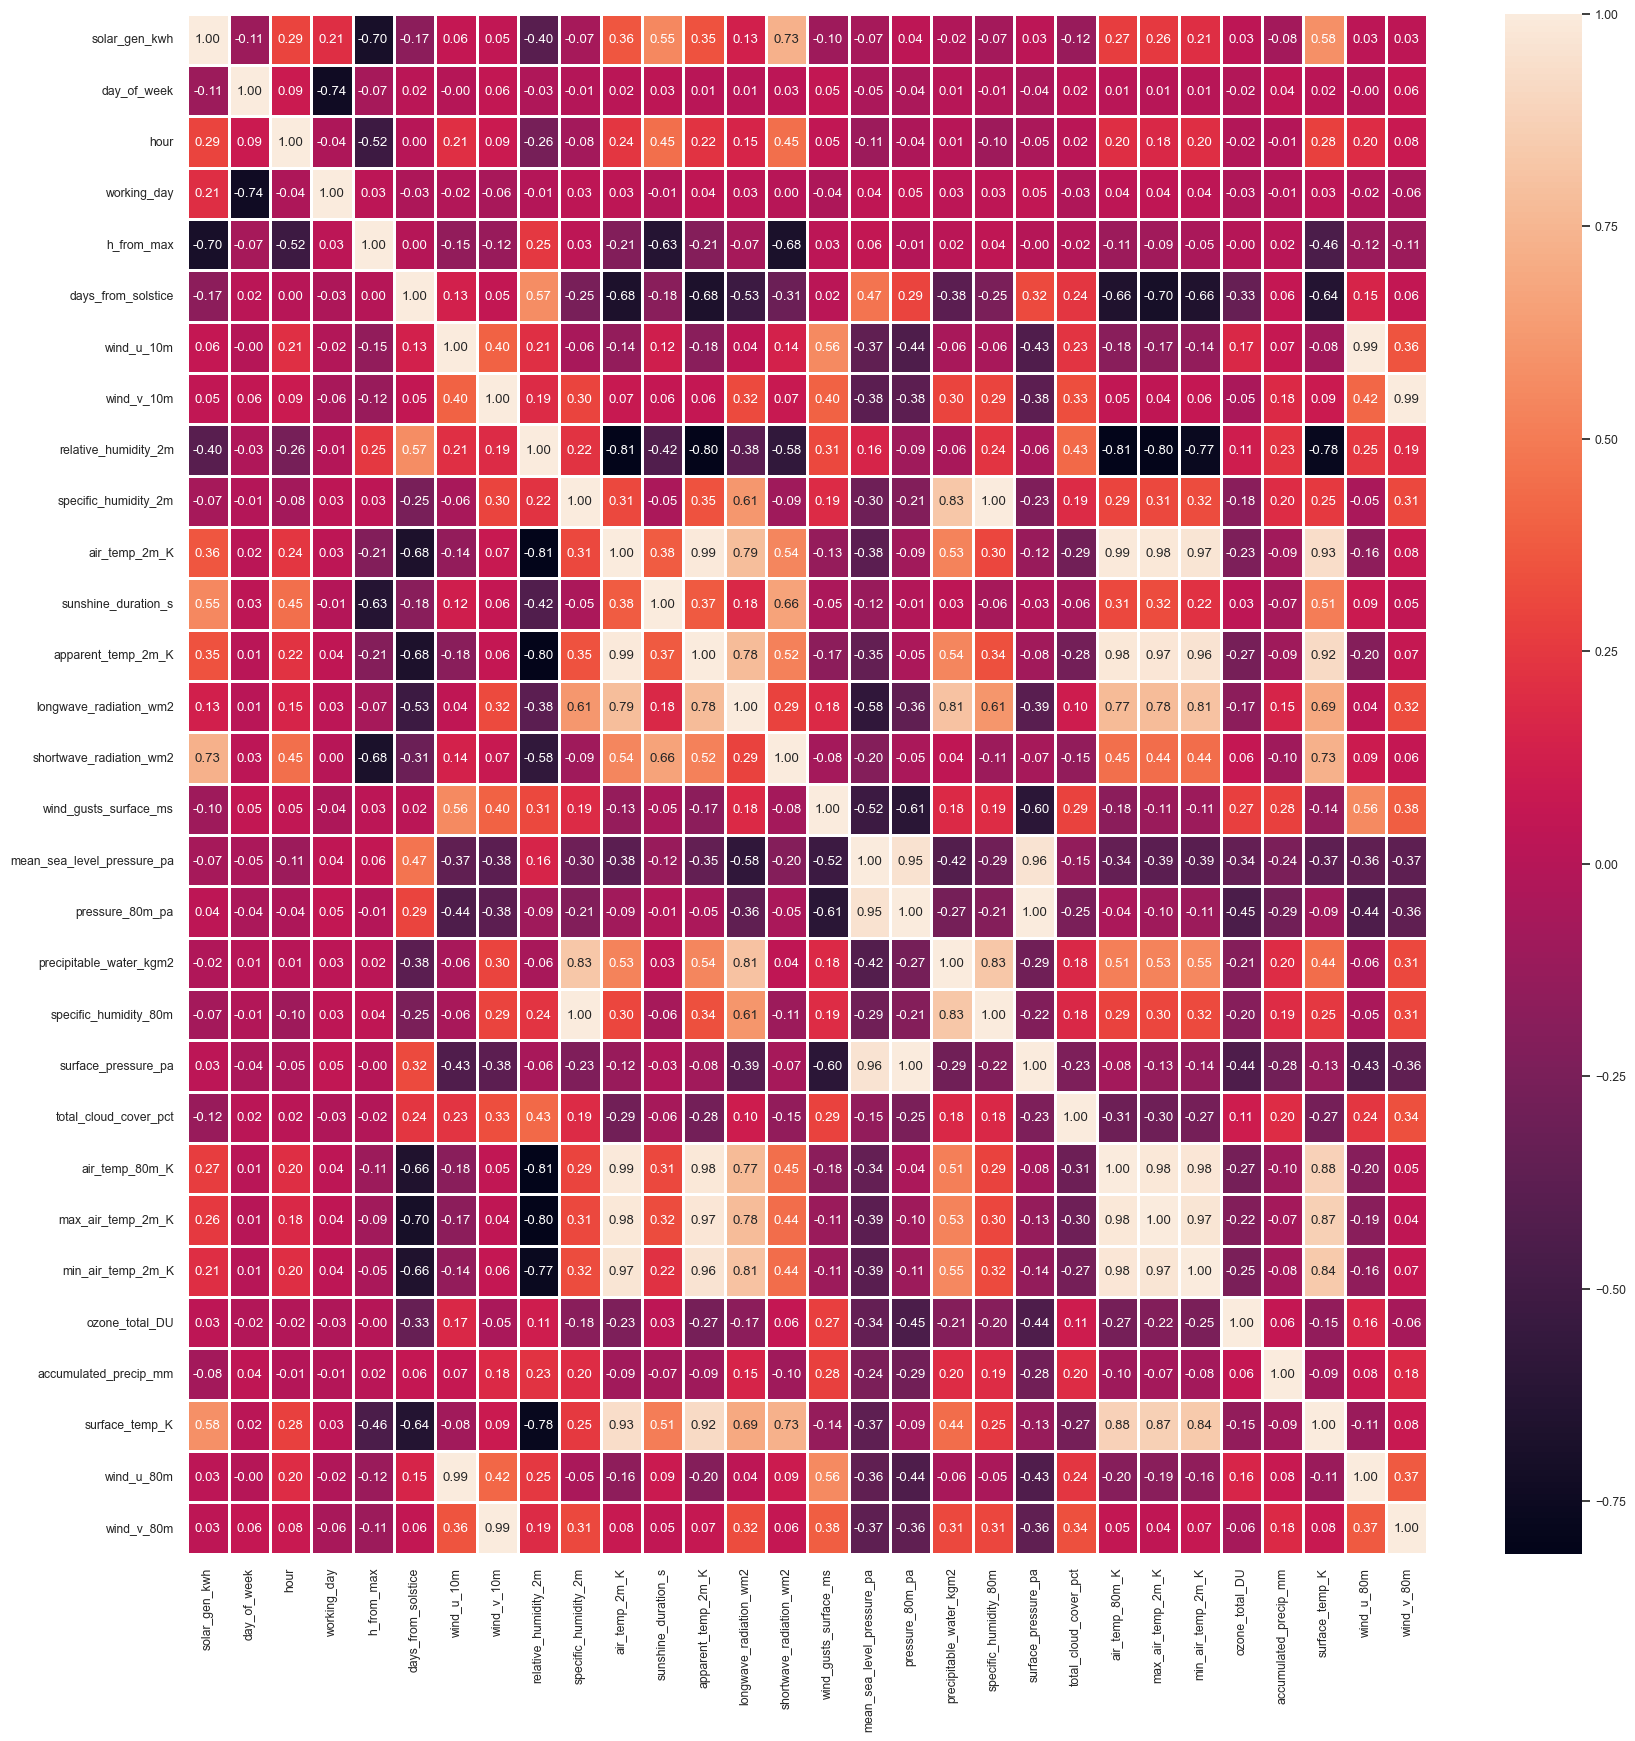

In [30]:
# and heatmap to show correlation between explanatory variables
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(20,20))         
sns.heatmap(solar_weather.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

In [31]:
solar_weather.to_csv('data/processed/solar_weather.csv')

# 🧪 Test Dataset Preparation

Here, the September 2024 subset is extracted from the full meteorological dataset. This is the **forecasting window** required by Objective 1.

This test dataset (`test_data`) is clean, complete, and structured identically to the training data. It includes all engineered features needed by the model and will be used to produce hourly predictions of solar potential for September 2024.

---

In [32]:
# Create a test dataset with only September 2024 data
test_start = '2024-09-01 00:00:00+02:00'
test_end = '2024-09-30 23:00:00+02:00'
test_data = weather_data.loc[test_start:test_end].copy()
test_data.head()

,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,air_temp_2m_K,sunshine_duration_s,apparent_temp_2m_K,longwave_radiation_wm2,shortwave_radiation_wm2,wind_gusts_surface_ms,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
date,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00+02:00,-1.146470,1.536299,54.550,0.011581,298.343311,2558.5,298.345093,381.548291,5.852,3.280788,...,94203.359375,100.00,298.515059,300.965186,298.261621,302.245032,0.250000,297.627844,-1.734128,2.446875
2024-09-01 01:00:00+02:00,-2.874170,2.267241,59.100,0.011715,297.193311,2558.5,297.181726,385.129883,4.676,6.300134,...,94219.321875,99.80,297.055488,300.995068,297.078540,301.975220,0.656250,297.210291,-4.288169,3.649812
2024-09-01 02:00:00+02:00,-2.777146,2.297925,62.400,0.011887,296.461133,2558.5,296.487183,384.655627,3.896,6.509302,...,94239.028125,100.00,296.203398,300.965186,296.088379,301.068127,1.203125,296.411621,-4.081997,4.002195
2024-09-01 03:00:00+02:00,-1.863838,-0.321150,71.225,0.012559,295.212207,0.0,295.258582,372.213379,0.000,3.306677,...,94233.556250,100.00,295.039590,295.848828,295.045532,301.181348,0.468750,295.675000,-3.139570,0.153901
2024-09-01 04:00:00+02:00,-2.218616,0.163606,74.850,0.012661,294.518311,0.0,294.523181,369.888428,0.000,3.771576,...,94228.150000,99.85,294.279141,295.855518,294.352124,299.360120,1.093750,295.000977,-3.564639,0.889404


In [33]:
test_data['day_of_week'] = test_data.index.day_of_week
test_data['hour'] = test_data.index.hour
test_data['working_day'] = (test_data['day_of_week'] < 5).astype(int)
test_data['date'] = test_data.index.date
test_data['working_day'] = test_data.apply(lambda row: 0 if row['date'] in madrid_holidays else row['working_day'], axis=1)
test_data['h_from_max'] = test_data.apply(lambda row: hours_to_closest_peak(row['hour']), axis=1)
test_data['days_from_solstice'] = test_data.index.to_series().apply(days_to_closest_summer_solstice)
test_data.drop(columns=['date'], inplace=True)
test_data.head()

,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,air_temp_2m_K,sunshine_duration_s,apparent_temp_2m_K,longwave_radiation_wm2,shortwave_radiation_wm2,wind_gusts_surface_ms,...,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m,day_of_week,hour,working_day,h_from_max,days_from_solstice
date,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00+02:00,-1.146470,1.536299,54.550,0.011581,298.343311,2558.5,298.345093,381.548291,5.852,3.280788,...,302.245032,0.250000,297.627844,-1.734128,2.446875,6,0,0,10,72
2024-09-01 01:00:00+02:00,-2.874170,2.267241,59.100,0.011715,297.193311,2558.5,297.181726,385.129883,4.676,6.300134,...,301.975220,0.656250,297.210291,-4.288169,3.649812,6,1,0,11,72
2024-09-01 02:00:00+02:00,-2.777146,2.297925,62.400,0.011887,296.461133,2558.5,296.487183,384.655627,3.896,6.509302,...,301.068127,1.203125,296.411621,-4.081997,4.002195,6,2,0,12,72
2024-09-01 03:00:00+02:00,-1.863838,-0.321150,71.225,0.012559,295.212207,0.0,295.258582,372.213379,0.000,3.306677,...,301.181348,0.468750,295.675000,-3.139570,0.153901,6,3,0,11,72
2024-09-01 04:00:00+02:00,-2.218616,0.163606,74.850,0.012661,294.518311,0.0,294.523181,369.888428,0.000,3.771576,...,299.360120,1.093750,295.000977,-3.564639,0.889404,6,4,0,10,72


In [34]:
# Reorder columns to bring specified columns to the front
first_columns = ['day_of_week', 'hour', 'working_day', 'h_from_max', 'days_from_solstice']
remaining_columns = [col for col in test_data.columns if col not in first_columns]
test_data = test_data[first_columns + remaining_columns]

# Save the test dataset
test_data.to_csv('data/processed/test_data.csv')

test_data.head()

,day_of_week,hour,working_day,h_from_max,days_from_solstice,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,air_temp_2m_K,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
date,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00+02:00,6,0,0,10,72,-1.146470,1.536299,54.550,0.011581,298.343311,...,94203.359375,100.00,298.515059,300.965186,298.261621,302.245032,0.250000,297.627844,-1.734128,2.446875
2024-09-01 01:00:00+02:00,6,1,0,11,72,-2.874170,2.267241,59.100,0.011715,297.193311,...,94219.321875,99.80,297.055488,300.995068,297.078540,301.975220,0.656250,297.210291,-4.288169,3.649812
2024-09-01 02:00:00+02:00,6,2,0,12,72,-2.777146,2.297925,62.400,0.011887,296.461133,...,94239.028125,100.00,296.203398,300.965186,296.088379,301.068127,1.203125,296.411621,-4.081997,4.002195
2024-09-01 03:00:00+02:00,6,3,0,11,72,-1.863838,-0.321150,71.225,0.012559,295.212207,...,94233.556250,100.00,295.039590,295.848828,295.045532,301.181348,0.468750,295.675000,-3.139570,0.153901
2024-09-01 04:00:00+02:00,6,4,0,10,72,-2.218616,0.163606,74.850,0.012661,294.518311,...,94228.150000,99.85,294.279141,295.855518,294.352124,299.360120,1.093750,295.000977,-3.564639,0.889404



# 🤖 2. Predictive Modeling

---


## 2.1 Modelling Including Weekends and Holidays


---

## 🧼 Data Cleaning & Preprocessing

- The solar generation column `solar_gen_kwh` is checked for missing values.
- Missing generation values (often from nighttime hours) are **imputed with the average value per hour**, ensuring the cyclical pattern is preserved.
- The cleaned dataset is split into features `X` and target `y`, then further split into training and testing sets using an 80-20 split.

---

In [35]:
data = solar_weather

In [36]:
data.isna().sum()

solar_gen_kwh                 794
day_of_week                     0
hour                            0
working_day                     0
h_from_max                      0
days_from_solstice              0
wind_u_10m                      0
wind_v_10m                      0
relative_humidity_2m            0
specific_humidity_2m            0
air_temp_2m_K                   0
sunshine_duration_s             0
apparent_temp_2m_K              0
longwave_radiation_wm2          0
shortwave_radiation_wm2         0
wind_gusts_surface_ms           0
mean_sea_level_pressure_pa      0
pressure_80m_pa                 0
precipitable_water_kgm2         0
specific_humidity_80m           0
surface_pressure_pa             0
total_cloud_cover_pct           0
air_temp_80m_K                  0
max_air_temp_2m_K               0
min_air_temp_2m_K               0
ozone_total_DU                  0
accumulated_precip_mm           0
surface_temp_K                  0
wind_u_80m                      0
wind_v_80m    

In [37]:
####REVIEW
# Fill null values in solar_gen_kwh with mean values by hour
hourly_means = data.groupby(['hour'])['solar_gen_kwh'].mean()
print("Mean solar generation by hour:")
print(hourly_means)

# Create a mapping function to fill NaN values based on the hour
def fill_with_hourly_mean(row):
    if pd.isna(row['solar_gen_kwh']):
        return hourly_means[row['hour']]
    return row['solar_gen_kwh']

# Apply the function to fill NaN values
data['solar_gen_kwh'] = data.apply(fill_with_hourly_mean, axis=1)

# Verify that all NaN values have been filled
print("\nRemaining NaN values after filling:")
print(data.isna().sum())


Mean solar generation by hour:
hour
0      0.001541
1     -0.003520
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.023549
8      1.183267
9      7.760632
10    28.695621
11    50.621836
12    68.895014
13    78.345480
14    80.106723
15    76.471158
16    71.214479
17    60.665686
18    44.756648
19    26.658156
20    12.578520
21     2.978687
22     0.285475
23    -0.005559
Name: solar_gen_kwh, dtype: float64

Remaining NaN values after filling:
solar_gen_kwh                 0
day_of_week                   0
hour                          0
working_day                   0
h_from_max                    0
days_from_solstice            0
wind_u_10m                    0
wind_v_10m                    0
relative_humidity_2m          0
specific_humidity_2m          0
air_temp_2m_K                 0
sunshine_duration_s           0
apparent_temp_2m_K            0
longwave_radiation_wm2        0
shortwave_radiation_wm2       0
wind_gusts_surface_ms      

In [38]:
# Separate features from response field
X, y = data.iloc[:,1:], data.iloc[:,0]
print(X.shape)
print(y.shape)

# Partition dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9705, 29)
(9705,)
(7764, 29)
(1941, 29)
(7764,)
(1941,)


---

## 🌲 Random Forest Regression

---

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Define the base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Define the scorer (MAE as per the challenge)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up the Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the search
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (Negative):", grid_search.best_score_)

# Use the best estimator
rf_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE (Negative): -6.914089342811285


In [40]:
mae = mean_absolute_error(y_test, rf_model.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 6.5514


### 🌲 Random Forest Results

- The best Random Forest model achieved an MAE of **~6.55 kWh** on the test set.
- The model was then used to predict solar potential for each hour in September 2024.
- Output saved as: `RF_predictions.csv`

---

In [41]:
testRF = rf_model.predict(test_data)

df_RF = pd.DataFrame(testRF, index=test_data.index)

df_RF.to_csv('data/processed/RF_predictions.csv')

### 🚀 XGBoost

In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression tasks
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [1, 10]   # L2 regularization
}

# MAE scorer (lower is better, so we invert)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid search setup
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,            # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best MAE (Negative):", grid_search_xgb.best_score_)

# Save best model
xgb_model = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8}
Best MAE (Negative): -5.791478085228363


In [43]:
mae = mean_absolute_error(y_test, xgb_model.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 5.3985


### 🚀 XGBoost Results

- Hyperparameter tuning of the XGBoost regressor led to an even better result: **~5.39 kWh MAE**.
- This model was also used to forecast the full month of September 2024.
- Output saved as: `boosting_predictions.csv`

---

In [44]:
testBoosting = xgb_model.predict(test_data)

df_boosting = pd.DataFrame(testBoosting, index=test_data.index)

df_boosting.to_csv('data/processed/boosting_predictions.csv')

## 2.2 Modelling Excluding Weekends

In [45]:
data = solar_weather

# Fill null values in solar_gen_kwh with mean values by hour
hourly_means = data.groupby('hour')['solar_gen_kwh'].mean()
print("Mean solar generation by hour:")
print(hourly_means)

# Create a mapping function to fill NaN values based on the hour
def fill_with_hourly_mean(row):
    if pd.isna(row['solar_gen_kwh']):
        return hourly_means[row['hour']]
    return row['solar_gen_kwh']

# Apply the function to fill NaN values
data['solar_gen_kwh'] = data.apply(fill_with_hourly_mean, axis=1)

# Verify that all NaN values have been filled
print("\nRemaining NaN values after filling:")
print(data.isna().sum())

Mean solar generation by hour:
hour
0      0.001541
1     -0.003520
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.023549
8      1.183267
9      7.760632
10    28.695621
11    50.621836
12    68.895014
13    78.345480
14    80.106723
15    76.471158
16    71.214479
17    60.665686
18    44.756648
19    26.658156
20    12.578520
21     2.978687
22     0.285475
23    -0.005559
Name: solar_gen_kwh, dtype: float64

Remaining NaN values after filling:
solar_gen_kwh                 0
day_of_week                   0
hour                          0
working_day                   0
h_from_max                    0
days_from_solstice            0
wind_u_10m                    0
wind_v_10m                    0
relative_humidity_2m          0
specific_humidity_2m          0
air_temp_2m_K                 0
sunshine_duration_s           0
apparent_temp_2m_K            0
longwave_radiation_wm2        0
shortwave_radiation_wm2       0
wind_gusts_surface_ms      

In [46]:
# Filter out weekends (day_of_week 5 and 6 represent Saturday and Sunday)
data = data[data['working_day'] == 1]

# Check the shape of the dataframe after filtering
print("\nDataframe shape after removing weekends and holidays:")
print(data.shape)

# Display a sample of the filtered data
print("\nSample of filtered data:")
data.head()



Dataframe shape after removing weekends and holidays:
(6739, 30)

Sample of filtered data:


,solar_gen_kwh,day_of_week,hour,working_day,h_from_max,days_from_solstice,wind_u_10m,wind_v_10m,relative_humidity_2m,specific_humidity_2m,...,surface_pressure_pa,total_cloud_cover_pct,air_temp_80m_K,max_air_temp_2m_K,min_air_temp_2m_K,ozone_total_DU,accumulated_precip_mm,surface_temp_K,wind_u_80m,wind_v_80m
2023-07-24 13:00:00+02:00,129.98,0,13,1,1,33,5.552217,2.449463,17.100,0.004546,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.0,314.950012,6.439102,2.633457
2023-07-24 14:00:00+02:00,134.35,0,14,1,0,33,5.856357,3.034297,16.850,0.004803,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.0,316.800000,6.899175,3.333066
2023-07-24 15:00:00+02:00,133.90,0,15,1,1,33,6.528643,3.126870,16.650,0.005111,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.0,317.627295,7.832305,3.467959
2023-07-24 16:00:00+02:00,126.93,0,16,1,2,33,7.584705,2.043123,17.275,0.005530,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.0,316.915942,9.052161,2.211703
2023-07-24 17:00:00+02:00,121.22,0,17,1,3,33,7.519548,2.373379,17.225,0.005634,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.0,315.610266,8.981921,2.736133


In [47]:
# Separate features from response field
X, y = data.iloc[:,1:], data.iloc[:,0]
print(X.shape)
print(y.shape)

# Partition dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6739, 29)
(6739,)
(5391, 29)
(1348, 29)
(5391,)
(1348,)


---

## 🌲 Random Forest Regression

---

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Define the base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Define the scorer (MAE as per the challenge)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up the Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the search
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (Negative):", grid_search.best_score_)

# Use the best estimator
rf_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE (Negative): -6.618413686043543


In [49]:
mae = mean_absolute_error(y_test, rf_model.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 6.2275


In [50]:
testRF2 = rf_model.predict(test_data)

df_RF2 = pd.DataFrame(testRF2, index=test_data.index)

df_RF2.to_csv('data/processed/RF_predictions2.csv')

### 🌲 Random Forest Results

- The best Random Forest model achieved an MAE of **~6.22 kWh** on the test set.
- The model was then used to predict solar potential for each hour in September 2024.
- Output saved as: `RF_predictions.csv`

---

### 🚀 XGBoost

In [51]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression tasks
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [1, 10]   # L2 regularization
}

# MAE scorer (lower is better, so we invert)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid search setup
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,            # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best MAE (Negative):", grid_search_xgb.best_score_)

# Save best model
xgb_model = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.8}
Best MAE (Negative): -5.68818830427202


In [52]:
mae = mean_absolute_error(y_test, xgb_model.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 5.1185


In [53]:
testBoosting2 = xgb_model.predict(test_data)

df_boosting2 = pd.DataFrame(testBoosting2, index=test_data.index)

df_boosting2.to_csv('data/processed/boosting_predictions2.csv')

### 🚀 XGBoost Results

- Hyperparameter tuning of the XGBoost regressor led to an even better result: **~5.12 kWh MAE**.
- This model was also used to forecast the full month of September 2024.
- Output saved as: `boosting_predictions.csv`

---

---

## 🧪 Model Comparison Summary

To estimate hourly solar generation potential for **September 2024**, several machine learning models were trained and evaluated. Below is a summary of the models tested, their settings, and performance:

| Model              | Description                            | MAE (on test set) | Notes |
|-------------------|----------------------------------------|-------------------|-------|
| **Random Forest**  | Ensemble of decision trees             | ~6.55 (Full data) <br> ~6.22 (Workdays only) | Solid baseline, good accuracy |
| **XGBoost**        | Gradient boosting on decision trees    | ~5.39 (Full data) <br> ~5.12 (Workdays only) | Best-performing model overall |
| **LSTM**           | Neural network using time sequences    | ~0.04 (Normalized MAE) | Captures temporal dependencies well, not exported as kWh |
| **Linear Regression** | Simple linear model                  | ~0.37 MAE (scaled) | Useful benchmark; less suited for nonlinear behavior |
| **Filtered Models** | Versions retrained with **weekends and holidays excluded** | All models improved MAE by ~0.3-0.4 points | Reflects real factory usage patterns |

### ✅ Forecast Output Files

Each model generated a set of predictions for September 2024, saved in `.csv` format with hourly timestamps. These files served as the basis for:

- **Underutilization calculation (Objective 1)**
- **Battery charge/discharge simulation (Objective 2)**
- **CO₂ emissions avoided estimation (Objective 3)**

---



In [54]:
import pandas as pd

# Load predicted solar potential (from model output)
df_predicted = pd.read_csv('data/processed/boosting_predictions2.csv', index_col=0, parse_dates=True)
df_predicted.columns = ['potential_kwh']

# Load actual consumed solar energy (file 5)
df_actual = pd.read_csv('data/raw/Consumo_fotovoltaica.csv', parse_dates=['FECHA'])
df_actual.set_index('FECHA', inplace=True)
df_actual.columns = ['actual_kwh']

df_combined = df_predicted.join(df_actual, how='inner')
df_combined.dropna(inplace=True)

# Compute underutilization: potential - actual
df_combined['underutilized_kwh'] = df_combined['potential_kwh'] - df_combined['actual_kwh']

# Clip negatives to 0 (in case model under-predicts actual usage)
df_combined['underutilized_kwh'] = df_combined['underutilized_kwh'].clip(lower=0)


total_underutilized = df_combined['underutilized_kwh'].sum()


print(f"Total Underutilization of the Installation (kWh): {total_underutilized:.4f}")


Total Underutilization of the Installation (kWh): 6214.5486


---

## ⚡ Objective 1 – Step 2: Underutilization of the Installation

In this step, we compared the **predicted solar generation potential** (from our XGBoost model) with the **actual photovoltaic energy consumed** by the factory during September 2024.

- The predicted values represent the **maximum energy that could have been generated and used**, based on weather conditions and optimal performance.
- The actual values were sourced from `Consumido_Fotovoltaica.csv`, which reflects the **real energy used** from solar panels at each hour.
- We computed the difference `underutilized_kwh = potential_kwh - actual_kwh`, ensuring no negative values (i.e., no overconsumption).

After summing across all hours in September:

**✅ Total Underutilization of the Installation: `6214.5486 kWh`**

This means that over 6,214 kWh of clean solar energy **could have been used by the factory** but went unused — primarily due to inactivity (e.g., weekends, holidays), overproduction, or lack of storage capacity.

This result will be used in the next step to simulate battery storage optimization.

---


---
## Objective 2 & 3- Battery Optimization for maximum usage and CO2 reduction

To solve objectives 2 & 3 we have built an optimization algorythm that resolves two problems at once. 

The reason this works is because when you try to minimize your co2 emissions you are inherently maximizing your battery usage up to the stated constraints, an then off-loading on periods of high co2 emission intensity. 

Objective 3 is thus a subest of Objective 2, so when you solve for co2 emissions you do for battery maximum usage but not otherwise. 

We have leverage the scipy.optimize module to build or custom optimization engine. We are deploying our optimization engine in a python script that we will then use in this notebook.

---

In [72]:
import pandas as pd
import numpy as np
from optimization_engine_vf import datathon_optimization_co2, datathon_optimization_ra

Let us load our predictions. We load them again for the optimization to be model agnostic.

In [73]:
prediction_dataset = 'data/processed/' + 'boosting_predictions2.csv'
predictions = pd.read_csv(prediction_dataset)

In [74]:
predictions.rename(columns={'date':'datetime', '0': 'solar_gen'}, inplace=True)
print(predictions.dtypes)
predictions['datetime'] = pd.to_datetime(predictions['datetime'])
predictions.set_index('datetime', inplace=True)
print(predictions.shape)
predictions.head()

datetime      object
solar_gen    float64
dtype: object
(720, 1)


,solar_gen
datetime,
2024-09-01 00:00:00+02:00,0.057649
2024-09-01 01:00:00+02:00,-0.109033
2024-09-01 02:00:00+02:00,0.021158
2024-09-01 03:00:00+02:00,-0.212883
2024-09-01 04:00:00+02:00,-0.184679


In [75]:
consumption = pd.read_csv('data/raw/consumo_sept.csv')
consumption.rename(columns={'FECHA': 'datetime', 'TOTAL_KWH_ENERGIA':'consumption'}, inplace=True)
consumption['datetime'] = pd.to_datetime(consumption['datetime'])
consumption.set_index('datetime', inplace=True)
consumption.index = consumption.index.tz_localize('Europe/Madrid', ambiguous='NaT', nonexistent='shift_forward')
print(consumption.shape)
consumption.head()

(720, 1)


,consumption
datetime,
2024-09-01 00:00:00+02:00,110.855888
2024-09-01 01:00:00+02:00,107.341202
2024-09-01 02:00:00+02:00,105.550308
2024-09-01 03:00:00+02:00,106.840103
2024-09-01 04:00:00+02:00,105.879791


In [123]:
#Approach 1 to CO2 - the main one we are using
#If we calculate CO2 emissions as the direct carbon intensity of electricity generation, measured in grams of CO₂ equivalent per kilowatt hour (gCO₂eq/kWh). 
#Assuming we are interested only in emissions from fossil fuel combustion without considering lifecycle emissions. 

co2 = pd.read_csv('data/raw/ES_2024_hourly.csv')
co2 = co2[['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (direct)']]
co2.rename(columns={'Datetime (UTC)': 'datetime', 'Carbon Intensity gCO₂eq/kWh (direct)': 'co2_emissions'}, inplace=True)
co2['datetime'] = pd.to_datetime(co2['datetime'], utc=True )
co2.set_index('datetime', inplace=True)
co2.index = co2.index.tz_convert('Europe/Madrid')
co2.head()

,co2_emissions
datetime,
2024-01-01 01:00:00+01:00,93.63
2024-01-01 02:00:00+01:00,93.64
2024-01-01 03:00:00+01:00,98.90
2024-01-01 04:00:00+01:00,99.33
2024-01-01 05:00:00+01:00,102.59


In [124]:
#Alternatively, the second approach 2 to CO2 would be to calculate CO2 emissions using the lifecycle carbon intensity, 
#which includes emissions from fuel extraction, processing, and power plant operations, providing a more comprehensive estimate of the environmental impact.  

# co2 = pd.read_csv('data/raw/ES_2024_hourly.csv')
# co2 = co2[['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (LCA)']]
# co2.rename(columns={'Datetime (UTC)': 'datetime', 'Carbon Intensity gCO₂eq/kWh (LCA)': 'co2_emissions'}, inplace=True)
# co2['datetime'] = pd.to_datetime(co2['datetime'], utc=True )
# co2.set_index('datetime', inplace=True)
# co2.index = co2.index.tz_convert('Europe/Madrid')
# co2.head()

We are going to join the three datasets. As they are all in Europe/Madrid tz we wll not have problems joining incorrectly the data. 
Also, as it is an 'inner' join, we are only getting the September data.

In [125]:
df = predictions.join(consumption, how='inner').join(co2, how='inner')
df.index = df.index.tz_convert('Europe/Madrid')
df['solar_usage'] = df.apply(lambda row: min(row['solar_gen'], row['consumption']), axis=1)
print(df.shape)
df.head()

(720, 4)


,solar_gen,consumption,co2_emissions,solar_usage
datetime,,,,
2024-09-01 00:00:00+02:00,0.057649,110.855888,158.77,0.057649
2024-09-01 01:00:00+02:00,-0.109033,107.341202,164.81,-0.109033
2024-09-01 02:00:00+02:00,0.021158,105.550308,170.04,0.021158
2024-09-01 03:00:00+02:00,-0.212883,106.840103,175.13,-0.212883
2024-09-01 04:00:00+02:00,-0.184679,105.879791,175.53,-0.184679


Let's calculate our base $R_a$. We can calculate dividing the solar generation by the direct usage.

In [126]:
base_ra = sum(df['solar_usage']) / sum(df['solar_gen'])
print('The base R_a without any battery usage is: ', "{:.2%}".format(base_ra) )

The base R_a without any battery usage is:  82.36%


---

### Optimization

Now it's time to run the optimization. We re going to call our custom function for our script. It is properly documented if anybody need to check its configuration.
We are going to call it in a loop once for every day in September, to account for all the restrictions.

---

In [127]:
hrs = 24
days = df.shape[0] // hrs
assert df.shape[0] / hrs == df.shape[0] // hrs, 'The dataset doesn\'t contain full day cycles'

x = np.array([])
print(x)

for day in range(days):
    start_index = day * 24
    end_index = (day + 1) * 24
    day_df = df.iloc[start_index:end_index]
    c = day_df['consumption'].to_numpy()
    s = day_df['solar_gen'].to_numpy()
    co2 = day_df['co2_emissions'].to_numpy()
    solution = datathon_optimization_ra(solar_generation=s,energy_consumption=c,co2=co2)
    x = np.append(x, solution.x)

[]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.883360160663692
            Iterations: 31
            Function evaluations: 775
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0
            Iterations: 9
            Function evaluations: 225
            Gradient evaluations: 9
Optimization 

In [128]:
df['battery_charge'] = x.round(4)
df['battery_usage'] = df.apply(lambda row: abs(row['battery_charge'] if row['battery_charge'] < 0 else 0), axis=1)
df['carbon_reduction'] = df.apply(lambda row: row['co2_emissions'] * row['battery_usage'] ,axis=1)
df['solar_surplus'] = np.maximum(0, df['solar_gen'] - df['consumption'])
df['false_results'] = df.apply(lambda row: round(row['battery_charge'],4) > round(row['solar_surplus'],4),axis=1)
df.head(10)

,solar_gen,consumption,co2_emissions,solar_usage,battery_charge,battery_usage,carbon_reduction,solar_surplus,false_results
datetime,,,,,,,,,
2024-09-01 00:00:00+02:00,0.057649,110.855888,158.77,0.057649,-0.0,0.0,0.0,0.0,False
2024-09-01 01:00:00+02:00,-0.109033,107.341202,164.81,-0.109033,-0.0,0.0,0.0,0.0,False
2024-09-01 02:00:00+02:00,0.021158,105.550308,170.04,0.021158,0.0,0.0,0.0,0.0,False
2024-09-01 03:00:00+02:00,-0.212883,106.840103,175.13,-0.212883,0.0,0.0,0.0,0.0,False
2024-09-01 04:00:00+02:00,-0.184679,105.879791,175.53,-0.184679,-0.0,0.0,0.0,0.0,False
2024-09-01 05:00:00+02:00,-0.318184,106.000397,174.22,-0.318184,-0.0,0.0,0.0,0.0,False
2024-09-01 06:00:00+02:00,-0.153076,105.497681,175.05,-0.153076,0.0,0.0,0.0,0.0,False
2024-09-01 07:00:00+02:00,-0.096250,101.122337,170.19,-0.096250,-0.0,0.0,0.0,0.0,False
2024-09-01 08:00:00+02:00,-0.035191,97.691238,159.95,-0.035191,-0.0,0.0,0.0,0.0,False


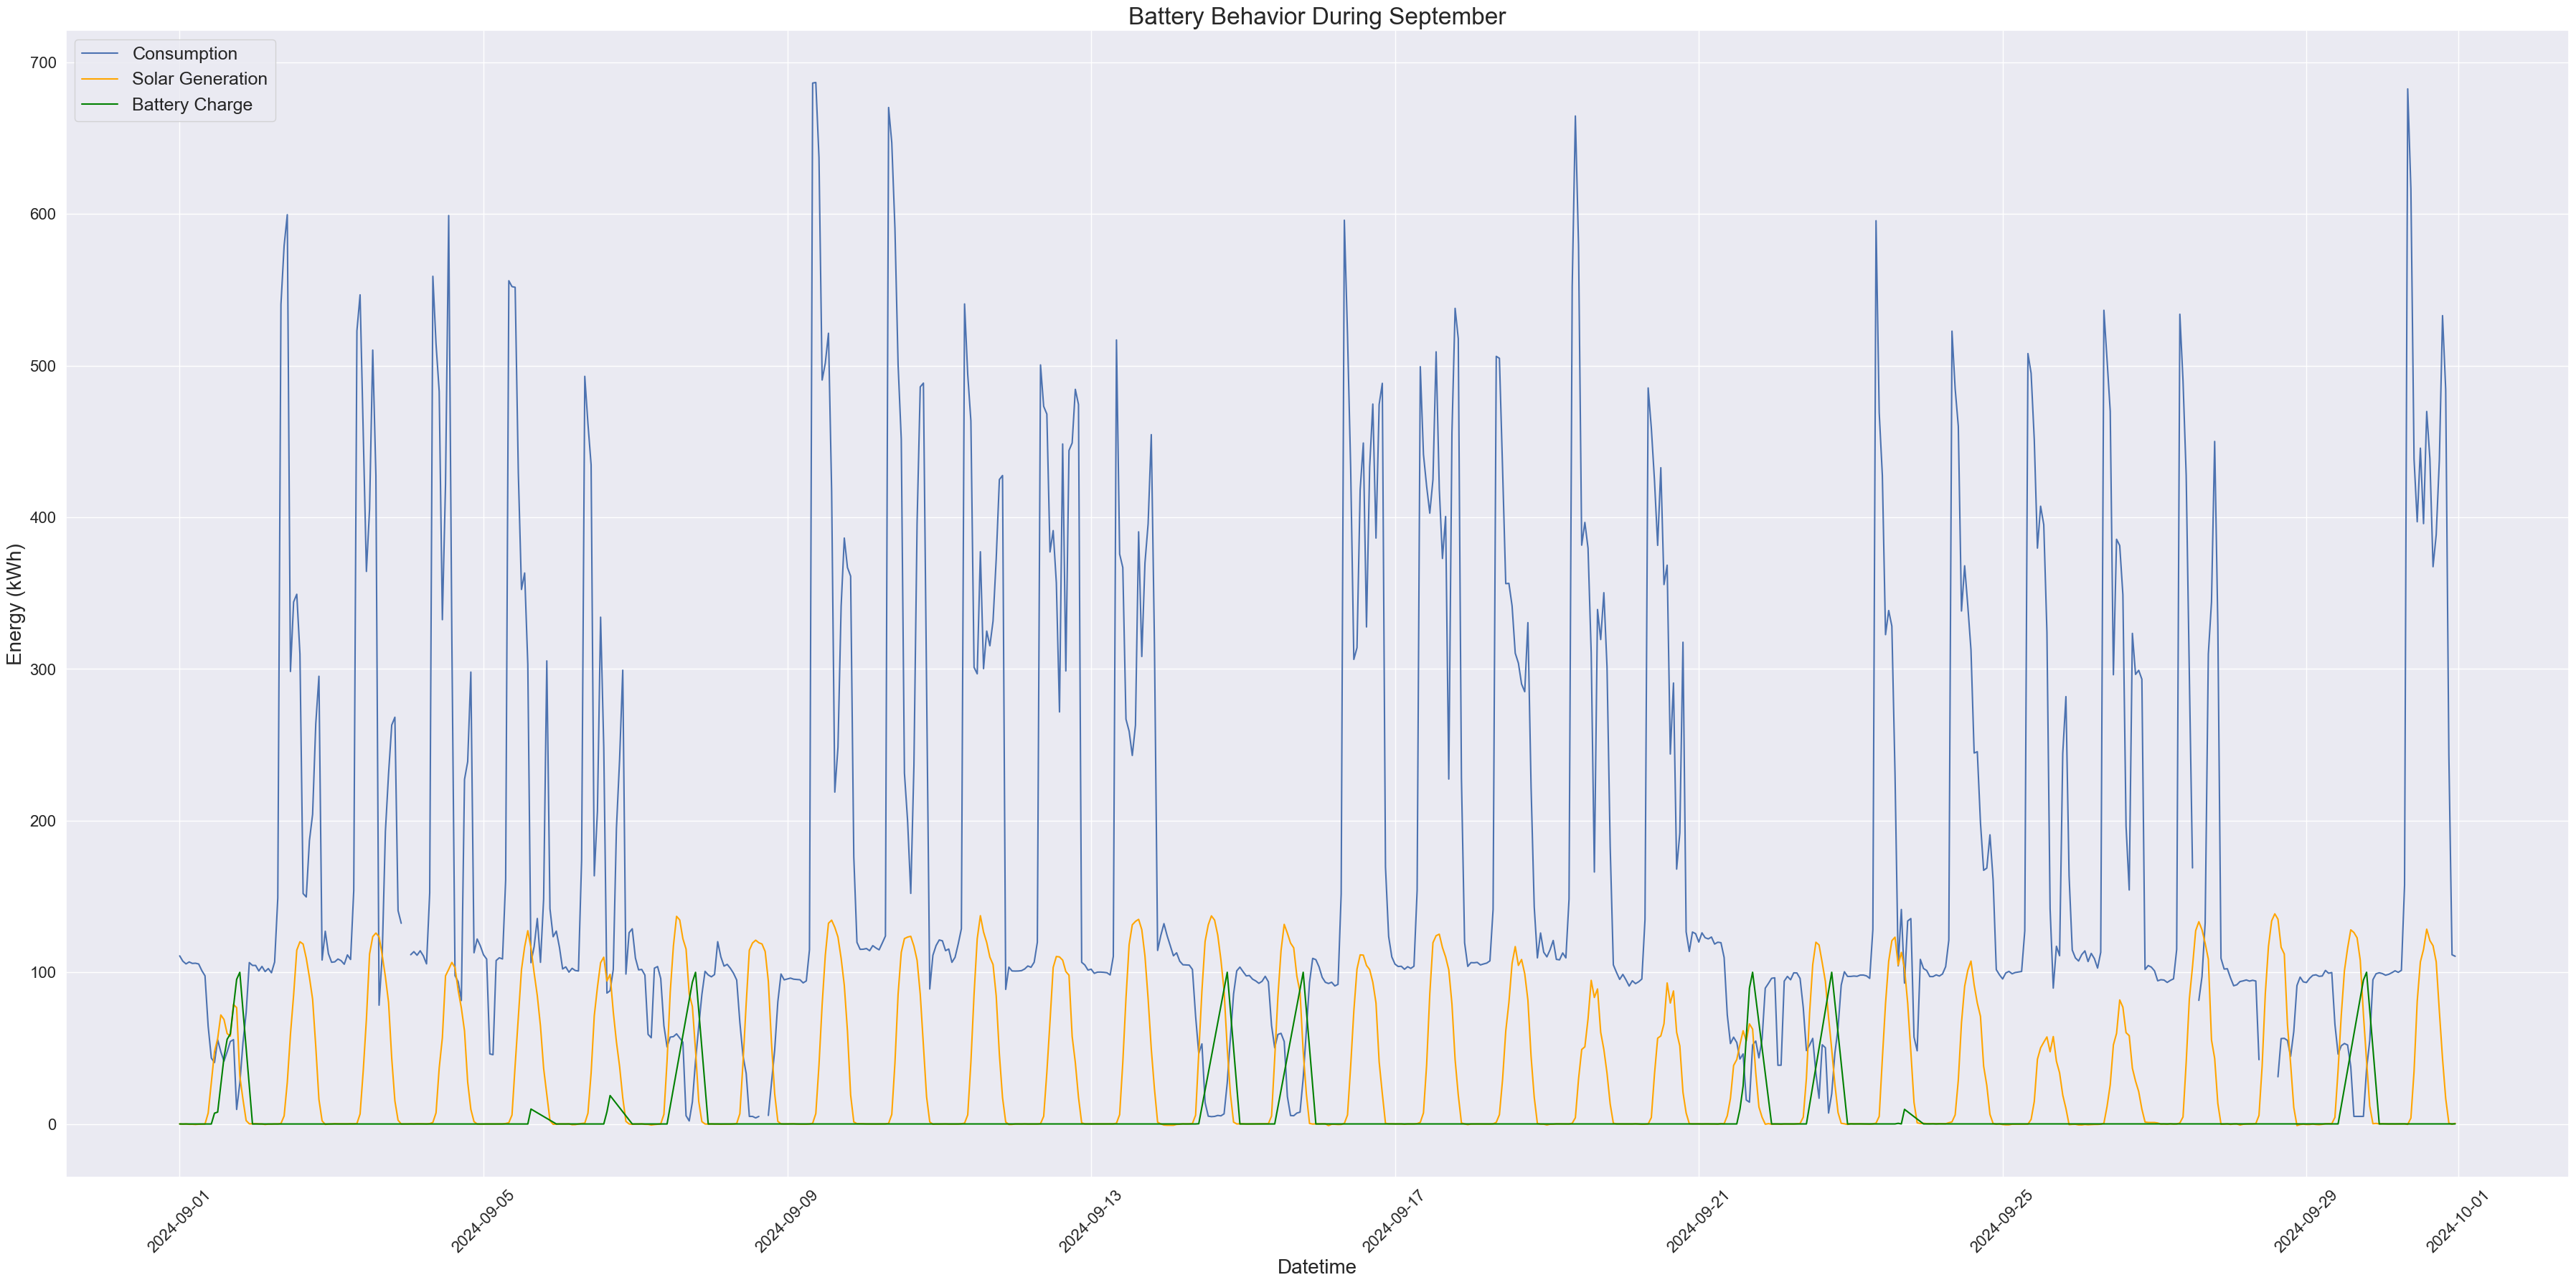

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(36, 18))

# 1. Plot consumption as a bar chart
ax.plot(df.index, df["consumption"], label="Consumption")

# 2. Plot solar generation as an orange line
ax.plot(df.index, df["solar_gen"], color="orange", label="Solar Generation")

# 3. Plot battery charge with two different colors depending on sign

ax.plot(
    df.index,
    df["battery_charge"].cumsum(),
    color="green",
    label="Battery Charge"
)


# Show legend and rotate x-labels if needed
ax.set_title("Battery Behavior During September", fontsize=24)
ax.set_xlabel("Datetime", fontsize=20)
ax.set_ylabel("Energy (kWh)", fontsize=20)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [130]:
base_ra2 = sum(df['solar_usage']) / sum(df['solar_gen'])
ra2 = (sum(df['solar_usage']) + sum(df['battery_usage'])) / sum(df['solar_gen'])
print('Base Ra factor of the facility without battery is: ', base_ra2)
print('Optimize Ra factor of the facility with battery is: ', ra2)
print('Co2 emissions reduction with optimization', df['carbon_reduction'].sum())

Base Ra factor of the facility without battery is:  0.8236457071658436
Optimize Ra factor of the facility with battery is:  0.8525673698942693
Co2 emissions reduction with optimization 88094.71384899999


In [131]:
df.to_csv('data/processed/optimization_Ra_result.csv')

In [132]:
hrs = 24
days = df.shape[0] // hrs
assert df.shape[0] / hrs == df.shape[0] // hrs, 'The dataset doesn\'t contain full day cycles'

x = np.array([])
print(x)

for day in range(days):
    start_index = day * 24
    end_index = (day + 1) * 24
    day_df = df.iloc[start_index:end_index]
    c = day_df['consumption'].to_numpy()
    s = day_df['solar_gen'].to_numpy()
    co2 = day_df['co2_emissions'].to_numpy()
    solution = datathon_optimization_co2(solar_generation=s,energy_consumption=c,co2=co2)
    x = np.append(x, solution.x)
    

x.shape

[]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17576.000415675957
            Iterations: 14
            Function evaluations: 321
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0001752710153920307
            Iterations: 2
            Function evaluations: 51
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1251802666814
            Iterations: 5
            Function evaluations: 126
            Gra

(720,)

Let's add some new fields to be able to interpret the results.
- `battery_charge`: is a floating point that can be positive (battery is recharging), negative (battery is powering the facility)
- `battery_usage`: is the actual battery power used in absolute terms
- `carbon_reduction`: the battery usage times the direct co2 at each t.
- `solar_surplus`: whenever the solar power has capacity to recharge
- `false_results`: simple check to validate that the battery charge is not greater than the solar_surplus (available power to charge)

In [133]:
df['battery_charge'] = x.round(4)
df['battery_usage'] = df.apply(lambda row: abs(row['battery_charge'] if row['battery_charge'] < 0 else 0), axis=1)
df['carbon_reduction'] = df.apply(lambda row: row['co2_emissions'] * row['battery_usage'] ,axis=1)
df['solar_surplus'] = np.maximum(0, df['solar_gen'] - df['consumption'])
df['false_results'] = df.apply(lambda row: round(row['battery_charge'],4) > round(row['solar_surplus'],4),axis=1)
df.head(10)

,solar_gen,consumption,co2_emissions,solar_usage,battery_charge,battery_usage,carbon_reduction,solar_surplus,false_results
datetime,,,,,,,,,
2024-09-01 00:00:00+02:00,0.057649,110.855888,158.77,0.057649,-0.0,0.0,0.0,0.0,False
2024-09-01 01:00:00+02:00,-0.109033,107.341202,164.81,-0.109033,-0.0,0.0,0.0,0.0,False
2024-09-01 02:00:00+02:00,0.021158,105.550308,170.04,0.021158,-0.0,0.0,0.0,0.0,False
2024-09-01 03:00:00+02:00,-0.212883,106.840103,175.13,-0.212883,-0.0,0.0,0.0,0.0,False
2024-09-01 04:00:00+02:00,-0.184679,105.879791,175.53,-0.184679,-0.0,0.0,0.0,0.0,False
2024-09-01 05:00:00+02:00,-0.318184,106.000397,174.22,-0.318184,-0.0,0.0,0.0,0.0,False
2024-09-01 06:00:00+02:00,-0.153076,105.497681,175.05,-0.153076,-0.0,0.0,0.0,0.0,False
2024-09-01 07:00:00+02:00,-0.096250,101.122337,170.19,-0.096250,-0.0,0.0,0.0,0.0,False
2024-09-01 08:00:00+02:00,-0.035191,97.691238,159.95,-0.035191,-0.0,0.0,0.0,0.0,False


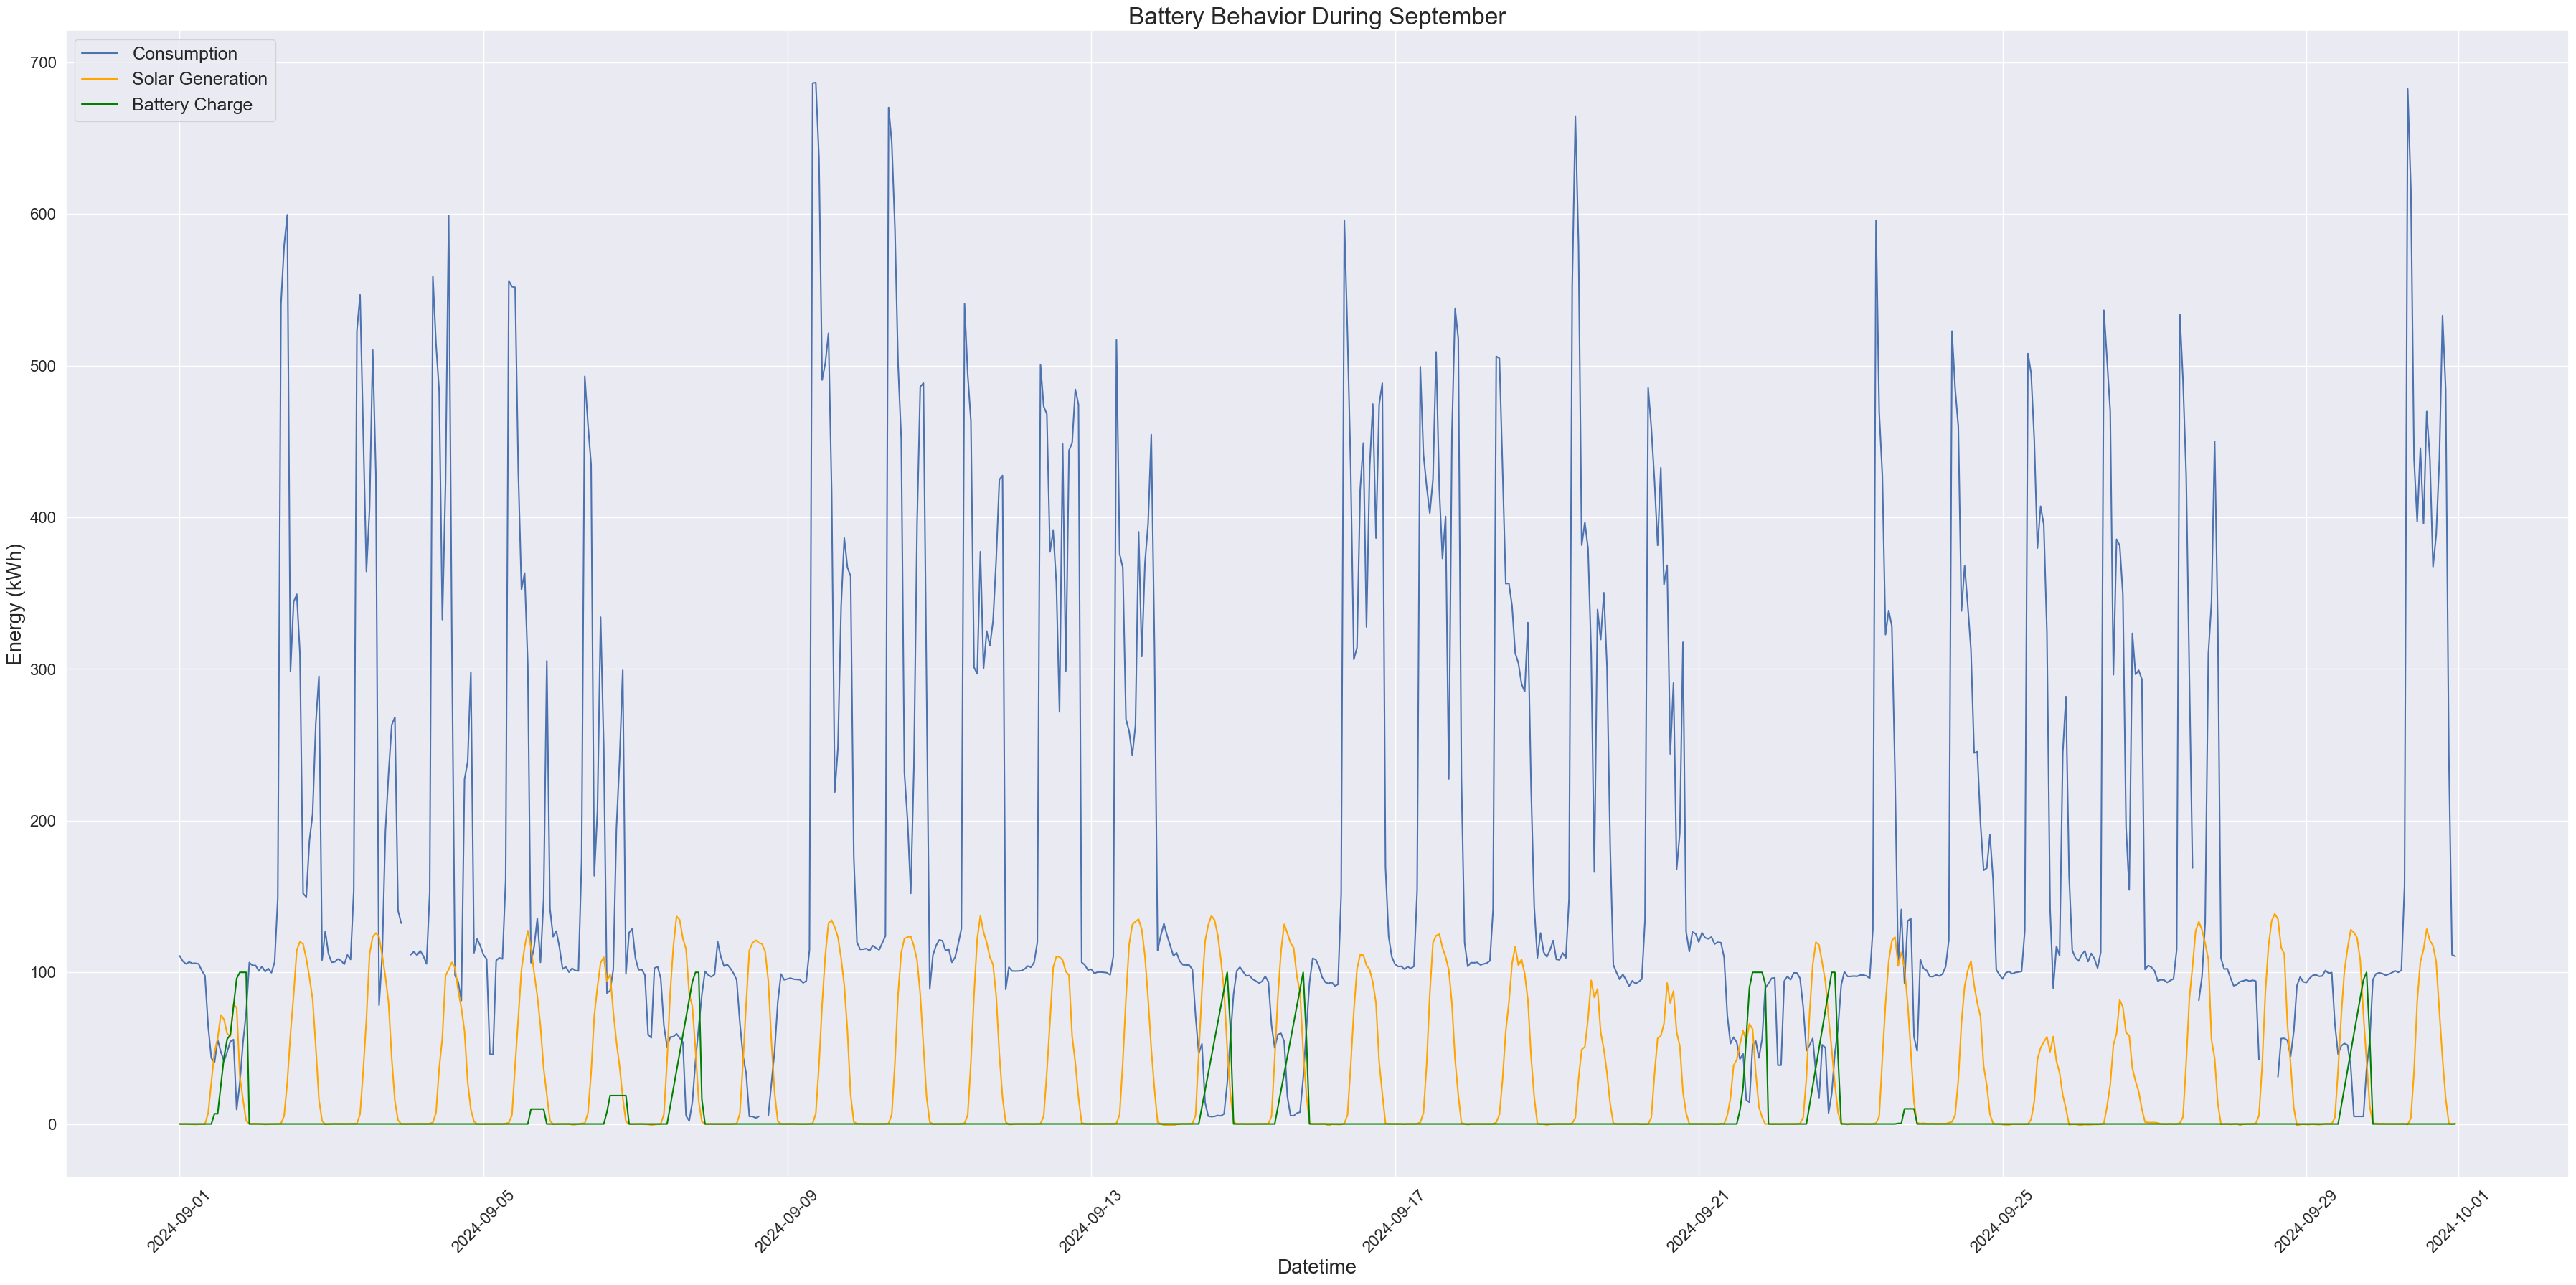

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(36, 18))

# 1. Plot consumption as a bar chart
ax.plot(df.index, df["consumption"], label="Consumption")

# 2. Plot solar generation as an orange line
ax.plot(df.index, df["solar_gen"], color="orange", label="Solar Generation")

# 3. Plot battery charge with two different colors depending on sign

ax.plot(
    df.index,
    df["battery_charge"].cumsum(),
    color="green",
    label="Battery Charge"
)

# Show legend and rotate x-labels if needed
ax.set_title("Battery Behavior During September", fontsize=24)
ax.set_xlabel("Datetime", fontsize=20)
ax.set_ylabel("Energy (kWh)", fontsize=20)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Now let's check the optimized $R_a$ and the CO2 emissions reduction

In [135]:
base_ra2 = sum(df['solar_usage']) / sum(df['solar_gen'])
ra2 = (sum(df['solar_usage']) + sum(df['battery_usage'])) / sum(df['solar_gen'])
print('Base Ra factor of the facility without battery is: ', base_ra2)
print('Optimize Ra factor of the facility with battery is: ', ra2)
print('Co2 emissions reduction with optimization', df['carbon_reduction'].sum())

Base Ra factor of the facility without battery is:  0.8236457071658436
Optimize Ra factor of the facility with battery is:  0.8525692809287715
Co2 emissions reduction with optimization 94158.219234


We are happy with the results, so let's save the optimization.

In [136]:
df.to_csv('data/processed/optimization_CO2_result.csv')

In [137]:
# If running the code with lifecycle CO2 emissions, then we would save the output in a separate csv file
# #df.to_csv('data/processed/optimization_CO2lifecycle_result.csv')

Now let's compare the optimized battery cycles for objectives 2 and 3

In [138]:
optimization_CO2_result = pd.read_csv("data\processed\optimization_CO2_result.csv")
optimization_Ra_result = pd.read_csv("data\processed\optimization_Ra_result.csv")

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\bburg\AppData\Local\Temp\ipykernel_41924\4252618395.py:1: SyntaxWarning: invalid escape sequence '\p'
  optimization_CO2_result = pd.read_csv("data\processed\optimization_CO2_result.csv")
C:\Users\bburg\AppData\Local\Temp\ipykernel_41924\4252618395.py:2: SyntaxWarning: invalid escape sequence '\p'
  optimization_Ra_result = pd.read_csv("data\processed\optimization_Ra_result.csv")


C:\Users\bburg\AppData\Local\Temp\ipykernel_41924\591910597.py:15: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
c:\Users\bburg\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


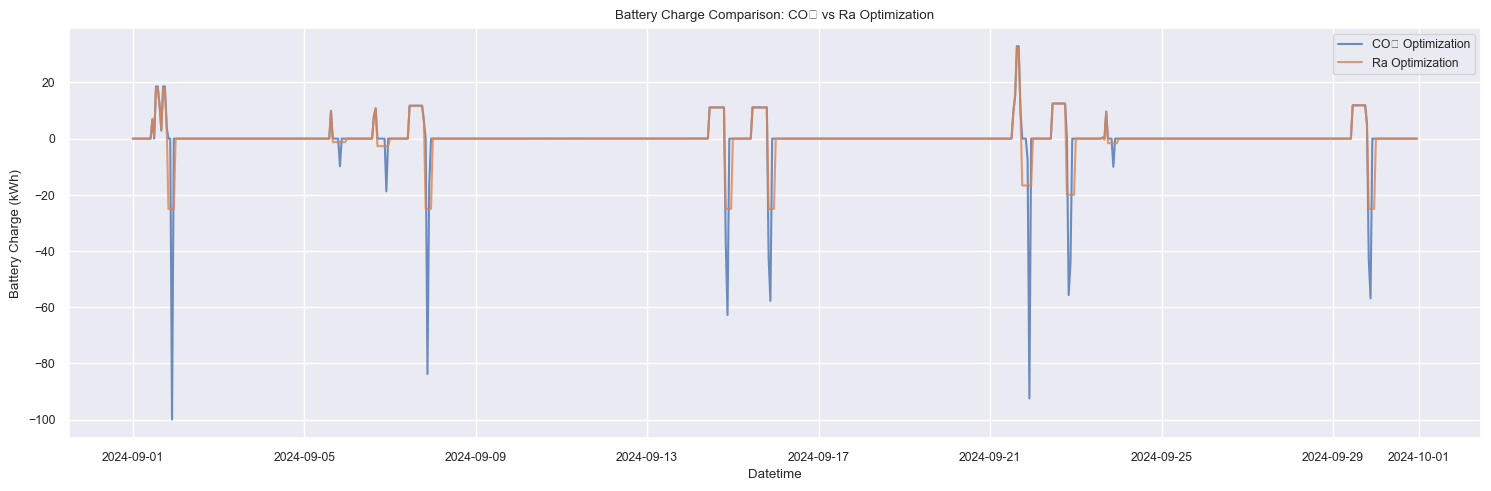

In [139]:
# Convert datetime column
optimization_CO2_result['datetime'] = pd.to_datetime(optimization_CO2_result['datetime'])
optimization_Ra_result['datetime'] = pd.to_datetime(optimization_Ra_result['datetime'])

# Plot
plt.figure(figsize=(15, 5))
plt.plot(optimization_CO2_result['datetime'], optimization_CO2_result['battery_charge'], label='CO₂ Optimization', alpha=0.8)
plt.plot(optimization_Ra_result['datetime'], optimization_Ra_result['battery_charge'], label='Ra Optimization', alpha=0.8)

plt.title("Battery Charge Comparison: CO₂ vs Ra Optimization")
plt.xlabel("Datetime")
plt.ylabel("Battery Charge (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis I ran to compare battery charges of optimizing avoided direct CO2 emissions vs lifecycle emissions

# optimization_CO2lifecycle_result = pd.read_csv("data\processed\optimization_CO2lifecycle_result.csv")
# optimization_CO2_result['datetime'] = pd.to_datetime(optimization_CO2_result['datetime'])
# #optimization_Ra_result['datetime'] = pd.to_datetime(optimization_Ra_result['datetime'])
# optimization_CO2lifecycle_result['datetime'] = pd.to_datetime(optimization_CO2lifecycle_result['datetime'])

# # Plot
# plt.figure(figsize=(15, 5))
# plt.plot(optimization_CO2_result['datetime'], optimization_CO2_result['battery_charge'], label='CO₂ Optimization', alpha=0.8)
# #plt.plot(optimization_Ra_result['datetime'], optimization_Ra_result['battery_charge'], label='Ra Optimization', alpha=0.8)
# plt.plot(optimization_CO2lifecycle_result['datetime'], optimization_CO2lifecycle_result['battery_charge'], label='CO₂ Lifecycle Optimization', alpha=0.8)

# plt.title("Battery Charge Comparison: CO₂ vs Ra Optimization")
# plt.xlabel("Datetime")
# plt.ylabel("Battery Charge (kWh)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()